### 1 ###
a) Due to central limit theorem, assuming a gaussian distribution is usually the best idea.

b) A spherical (or isotropic) covariance matrix is when the covariance matrix is proportional to the identity matrix, which means it is diagonal, and all diagonal elements are exactly the same. 

### 2 ###

$$
p(\mathbf{Y} | f, \mathbf{X}) = p(\bigcap_i^N (y_i | f, x_i))
$$

### 3 ###

$$
p(\mathbf{Y} | \mathbf{X}, \mathbf{W}) = \prod_{n=1}^{N} N(y_i | w^T\phi(x_n), \beta^{-1})
$$

Something to do with this:

$$
p(t | x, w) = N(t | y(x, w), \beta^{-1})
$$

Assumption is that the data points in Y are drawn independently from the distribution

### 4 ###

Conjugate distributions occur when a prior and a posterior distribution are of the same family, in this case the prior is called a conjugate prior.

A conjugate prior is helpful, as if we choose to use a Gaussian conjugate prior, it ensures that our posterior is also a Gaussian, since Gaussian distributions are conjugate to themselves.
A conjugate prior gives a closed-form expression for the posterior, which prevents integration which may be otherwise necessary.
Additionally, conjugate priors can more easily show how a likelihood function updates the prior.

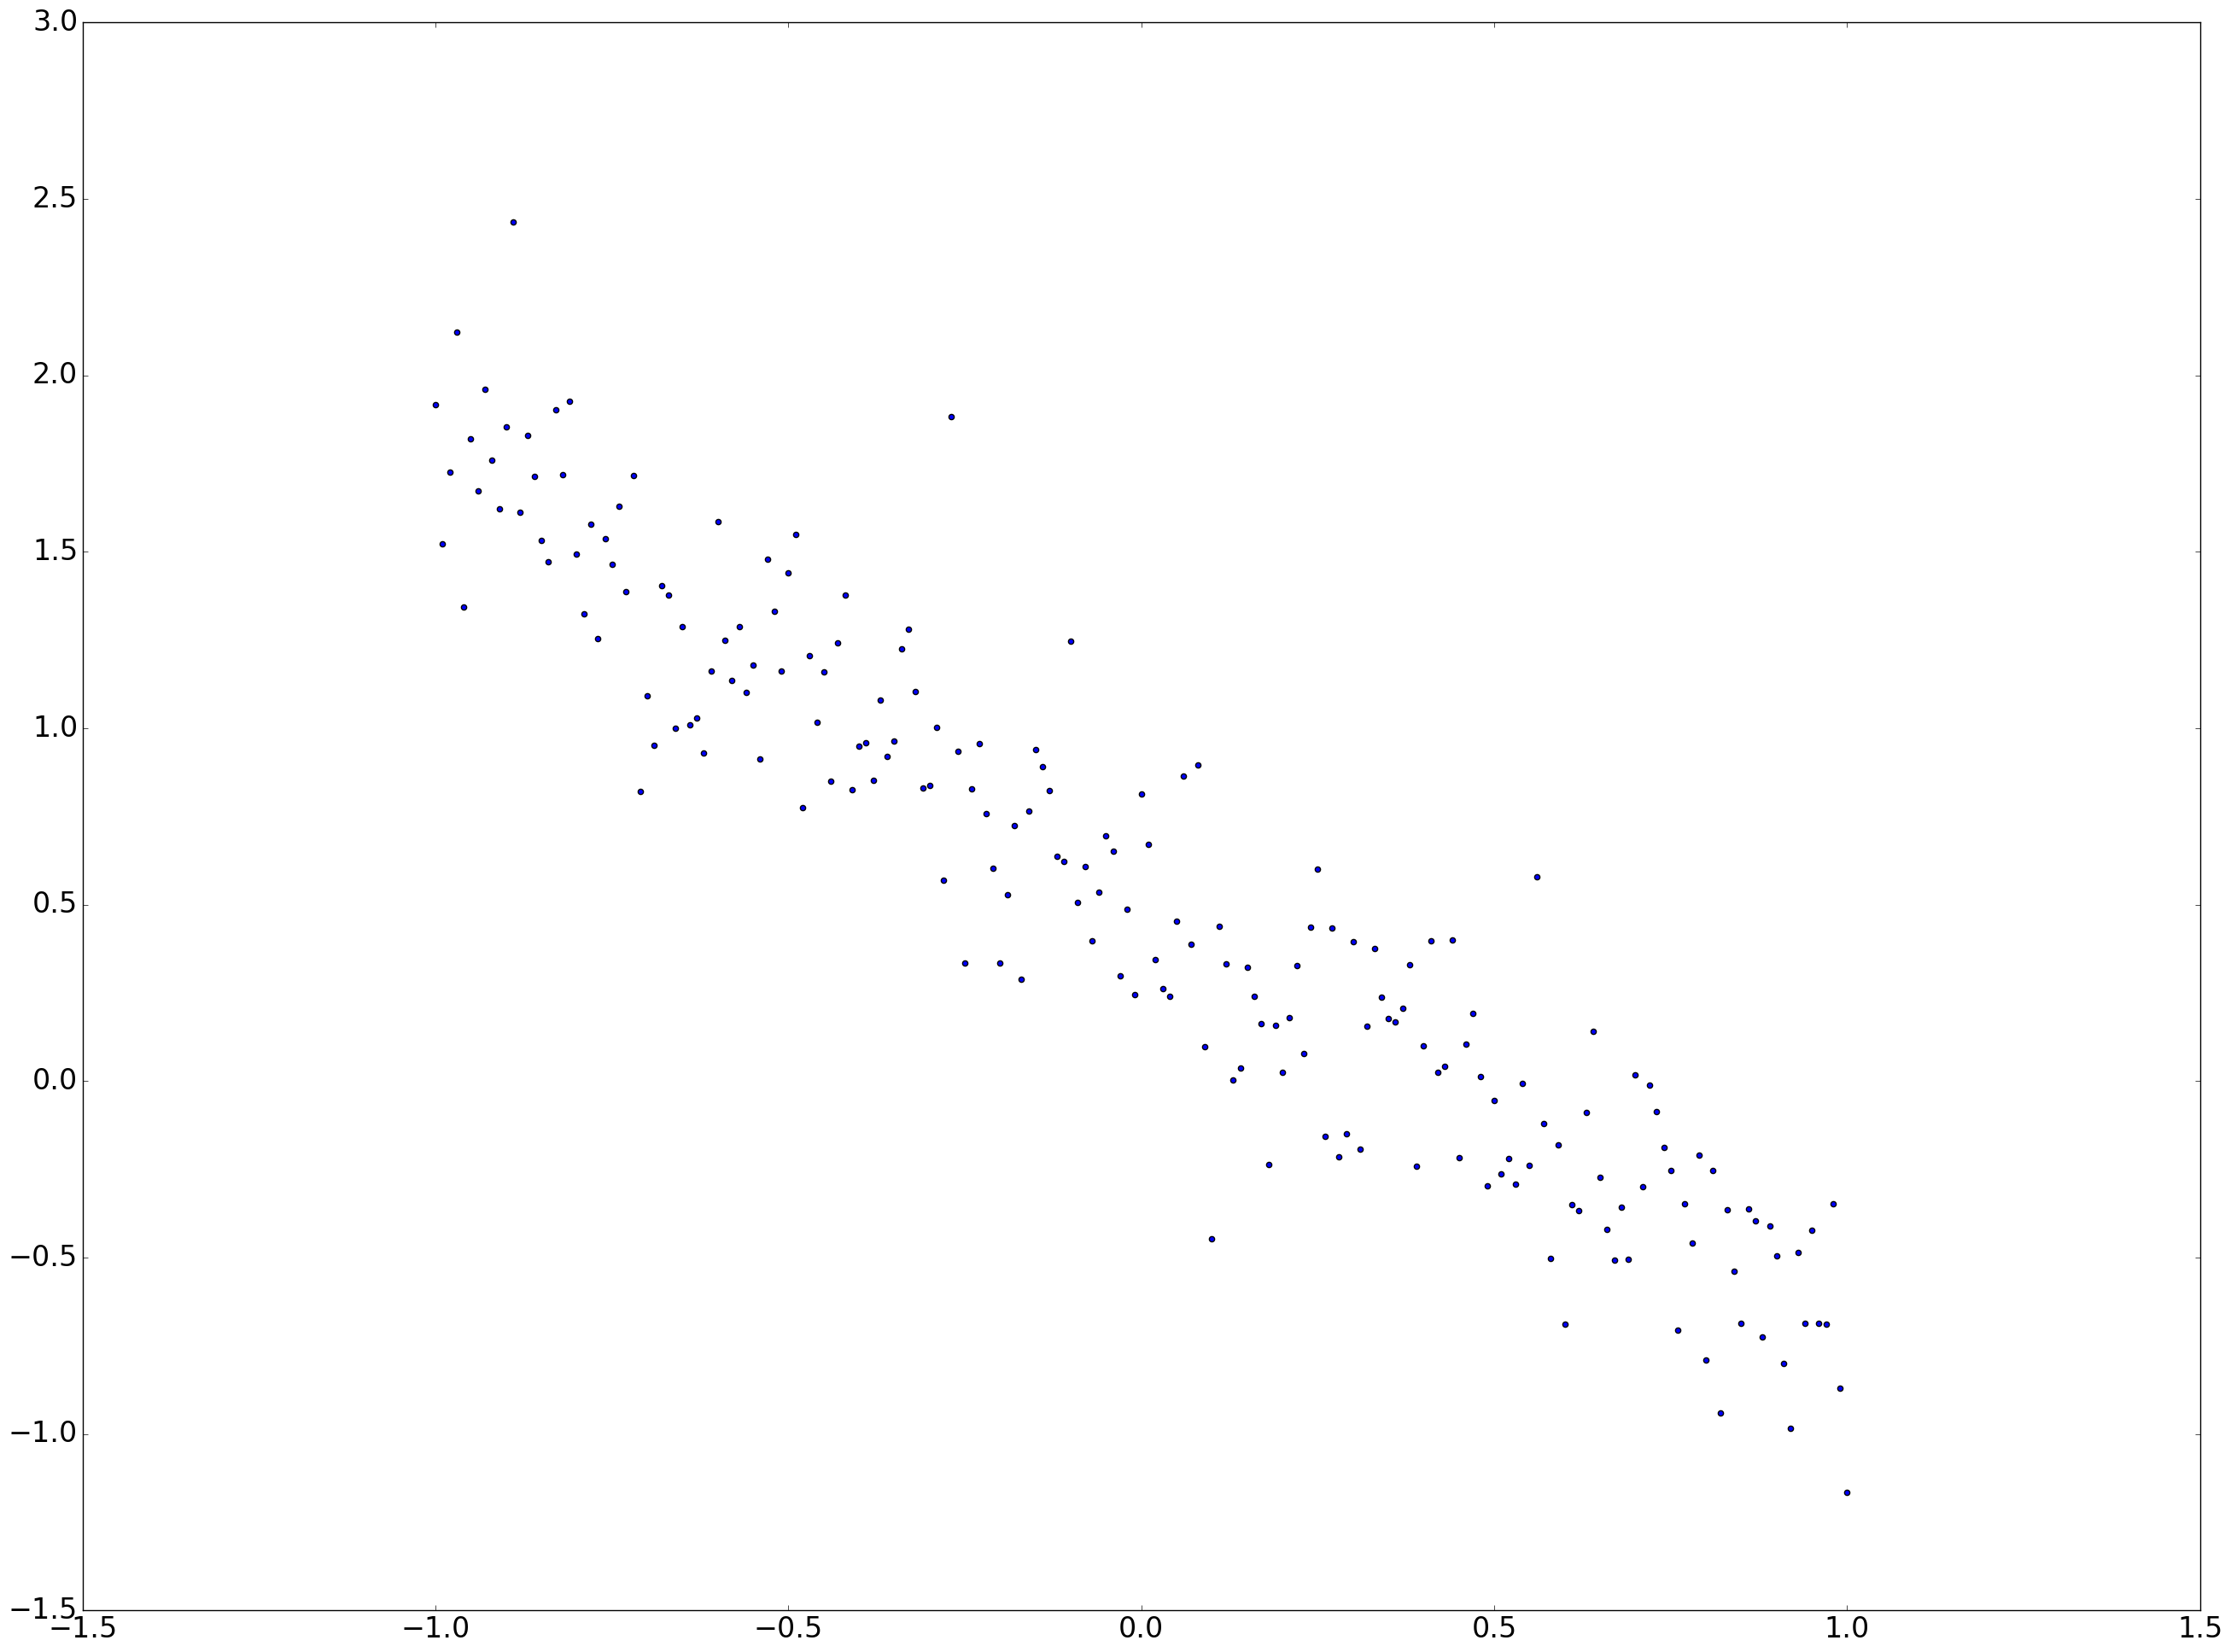

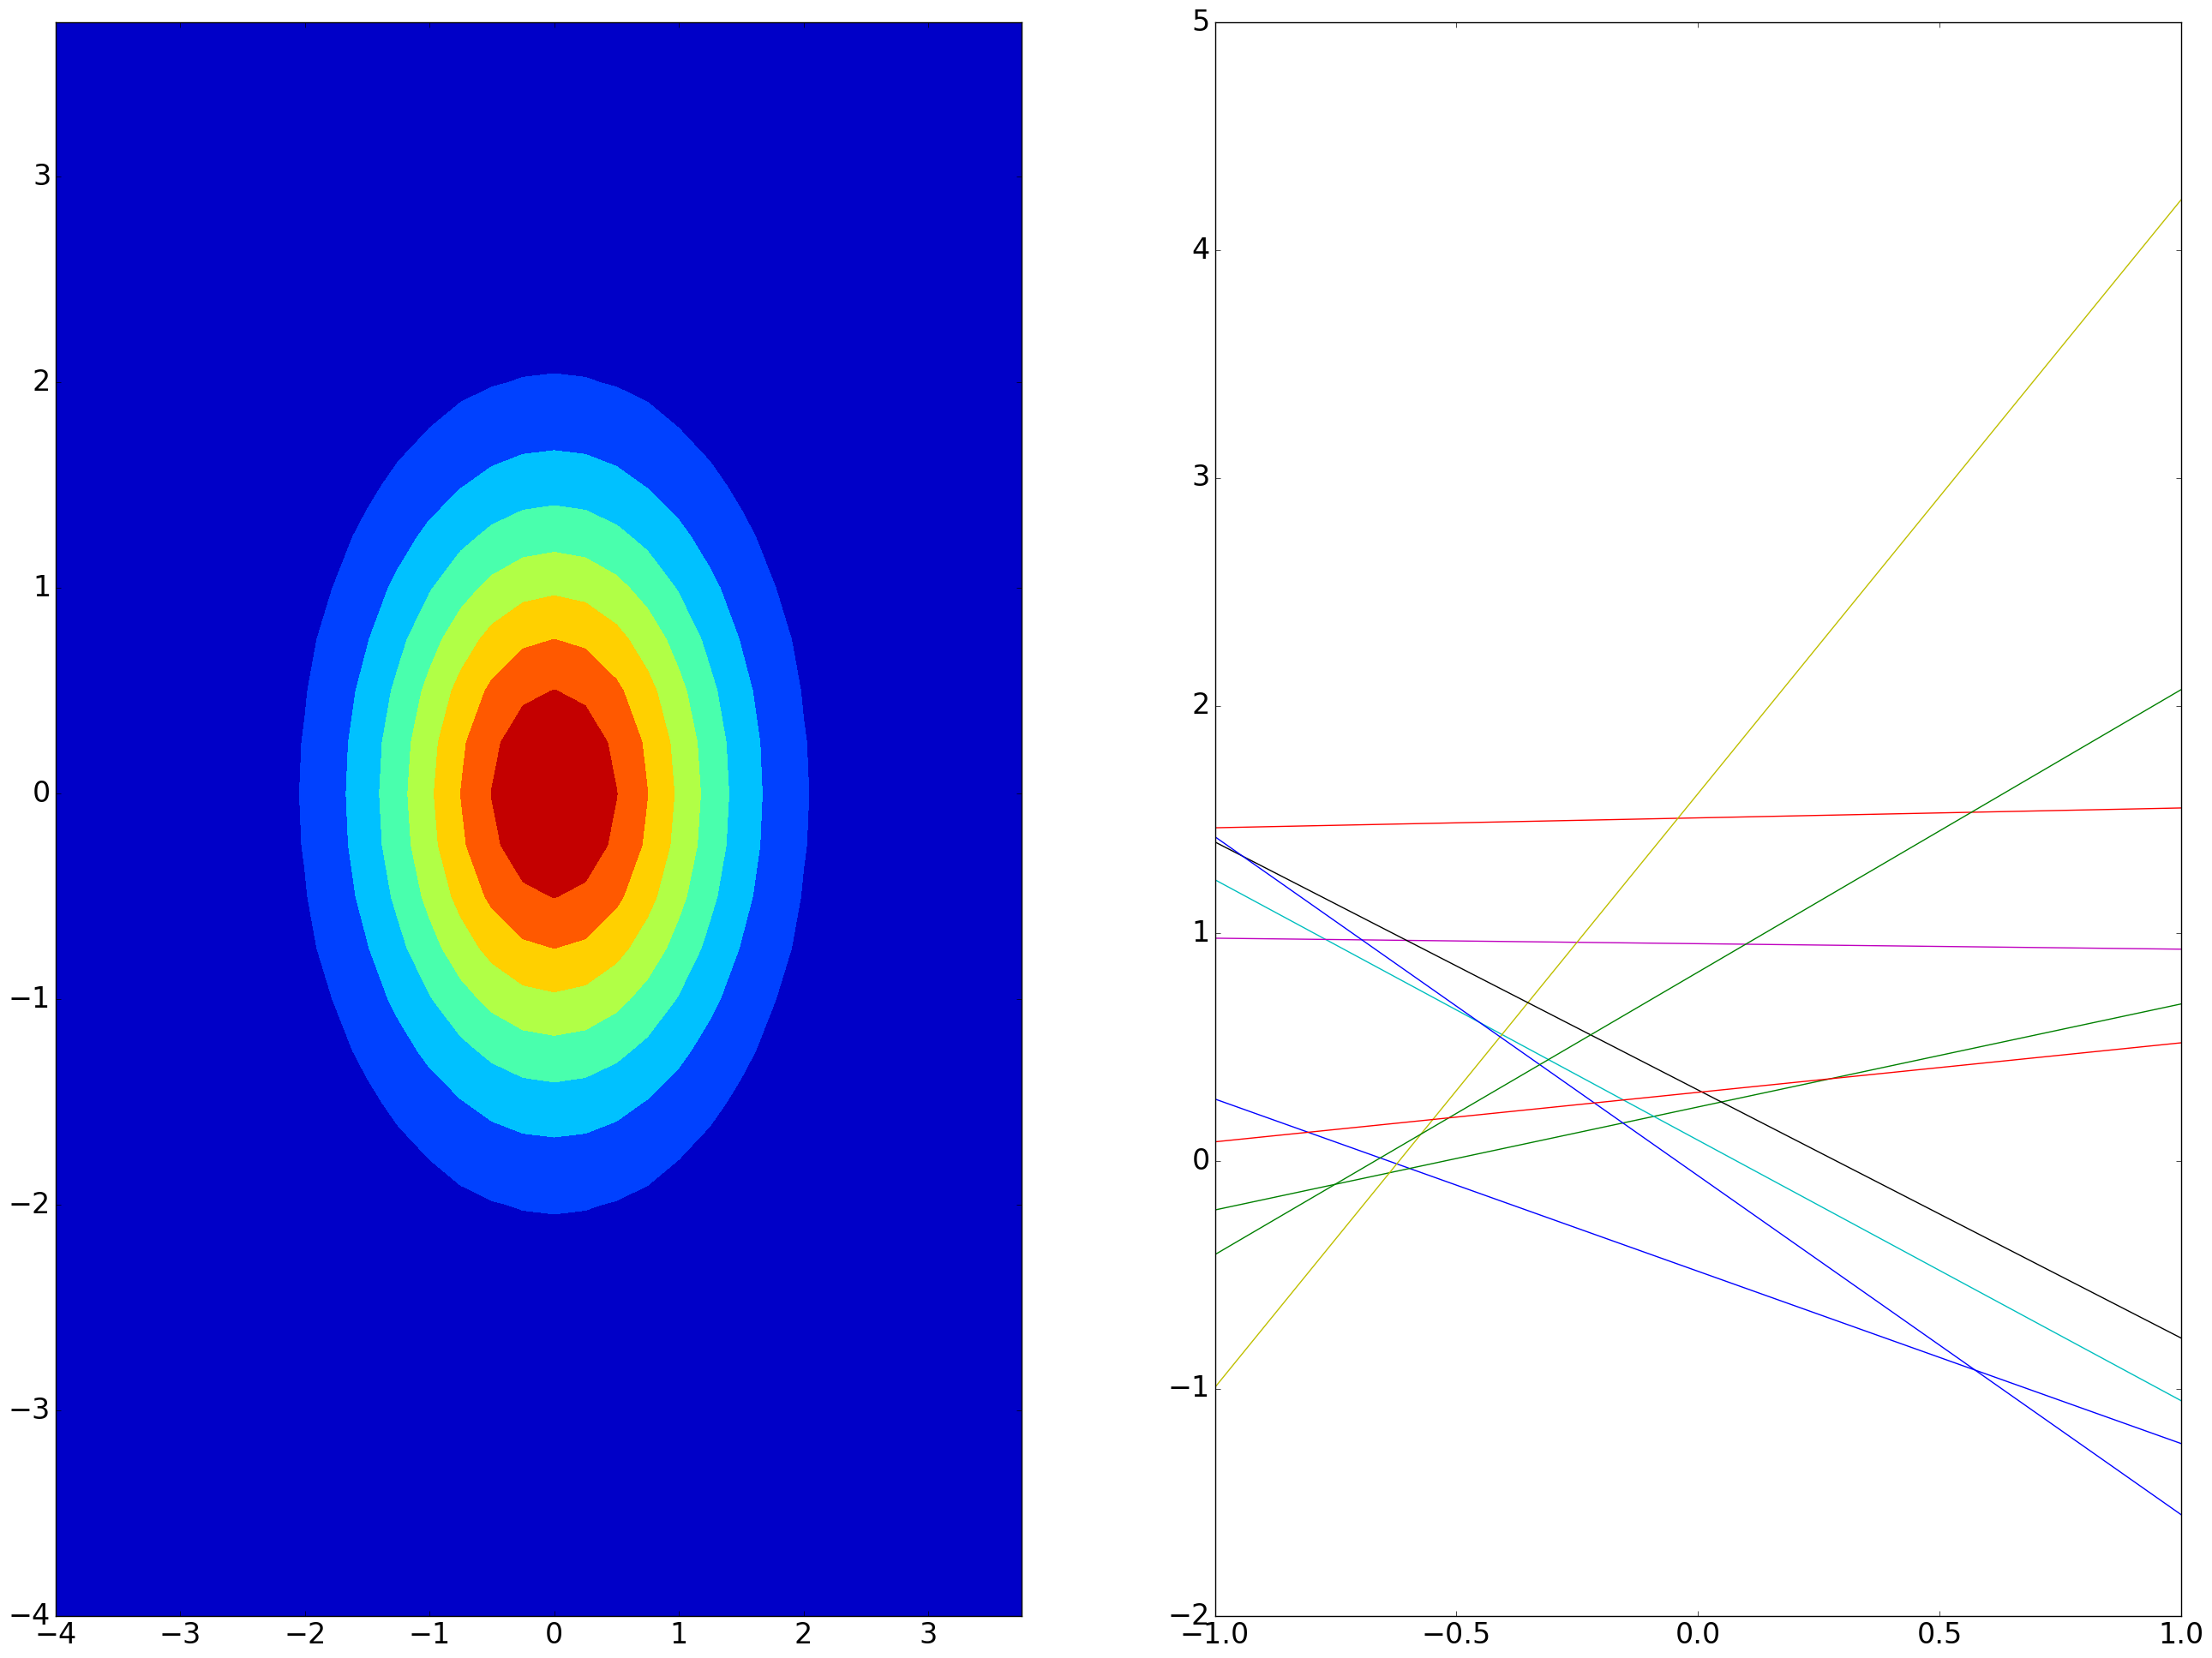

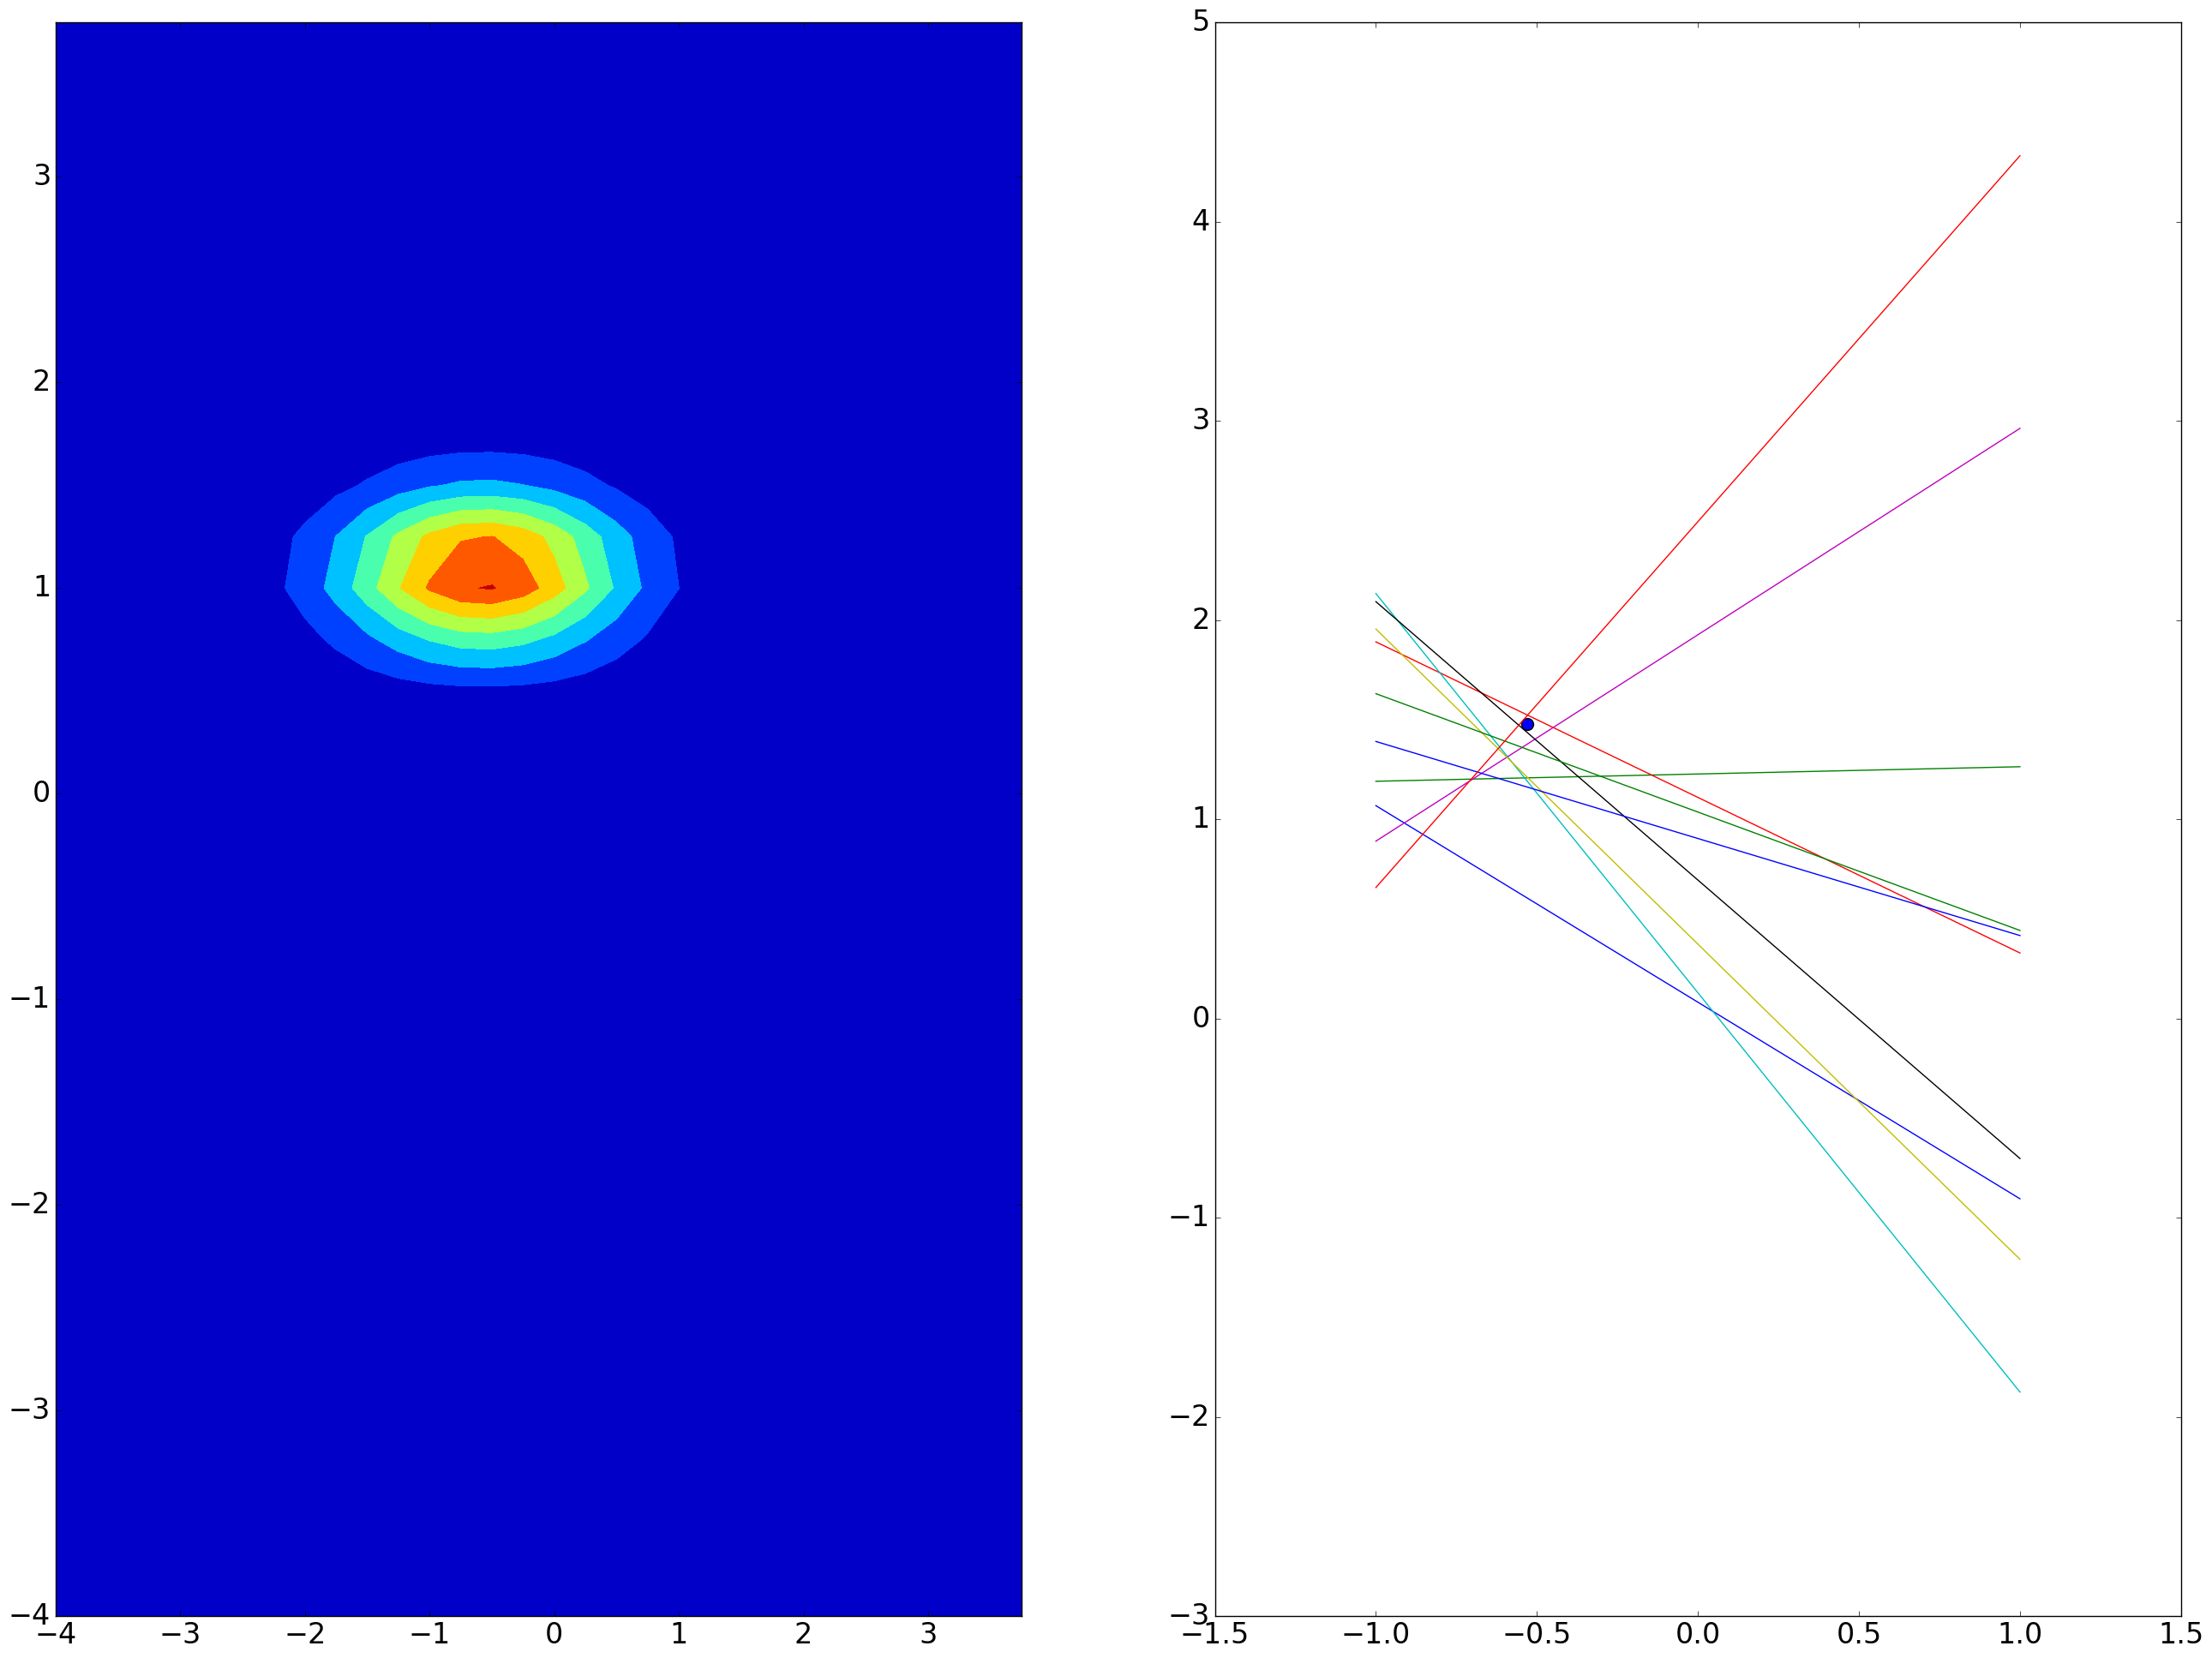

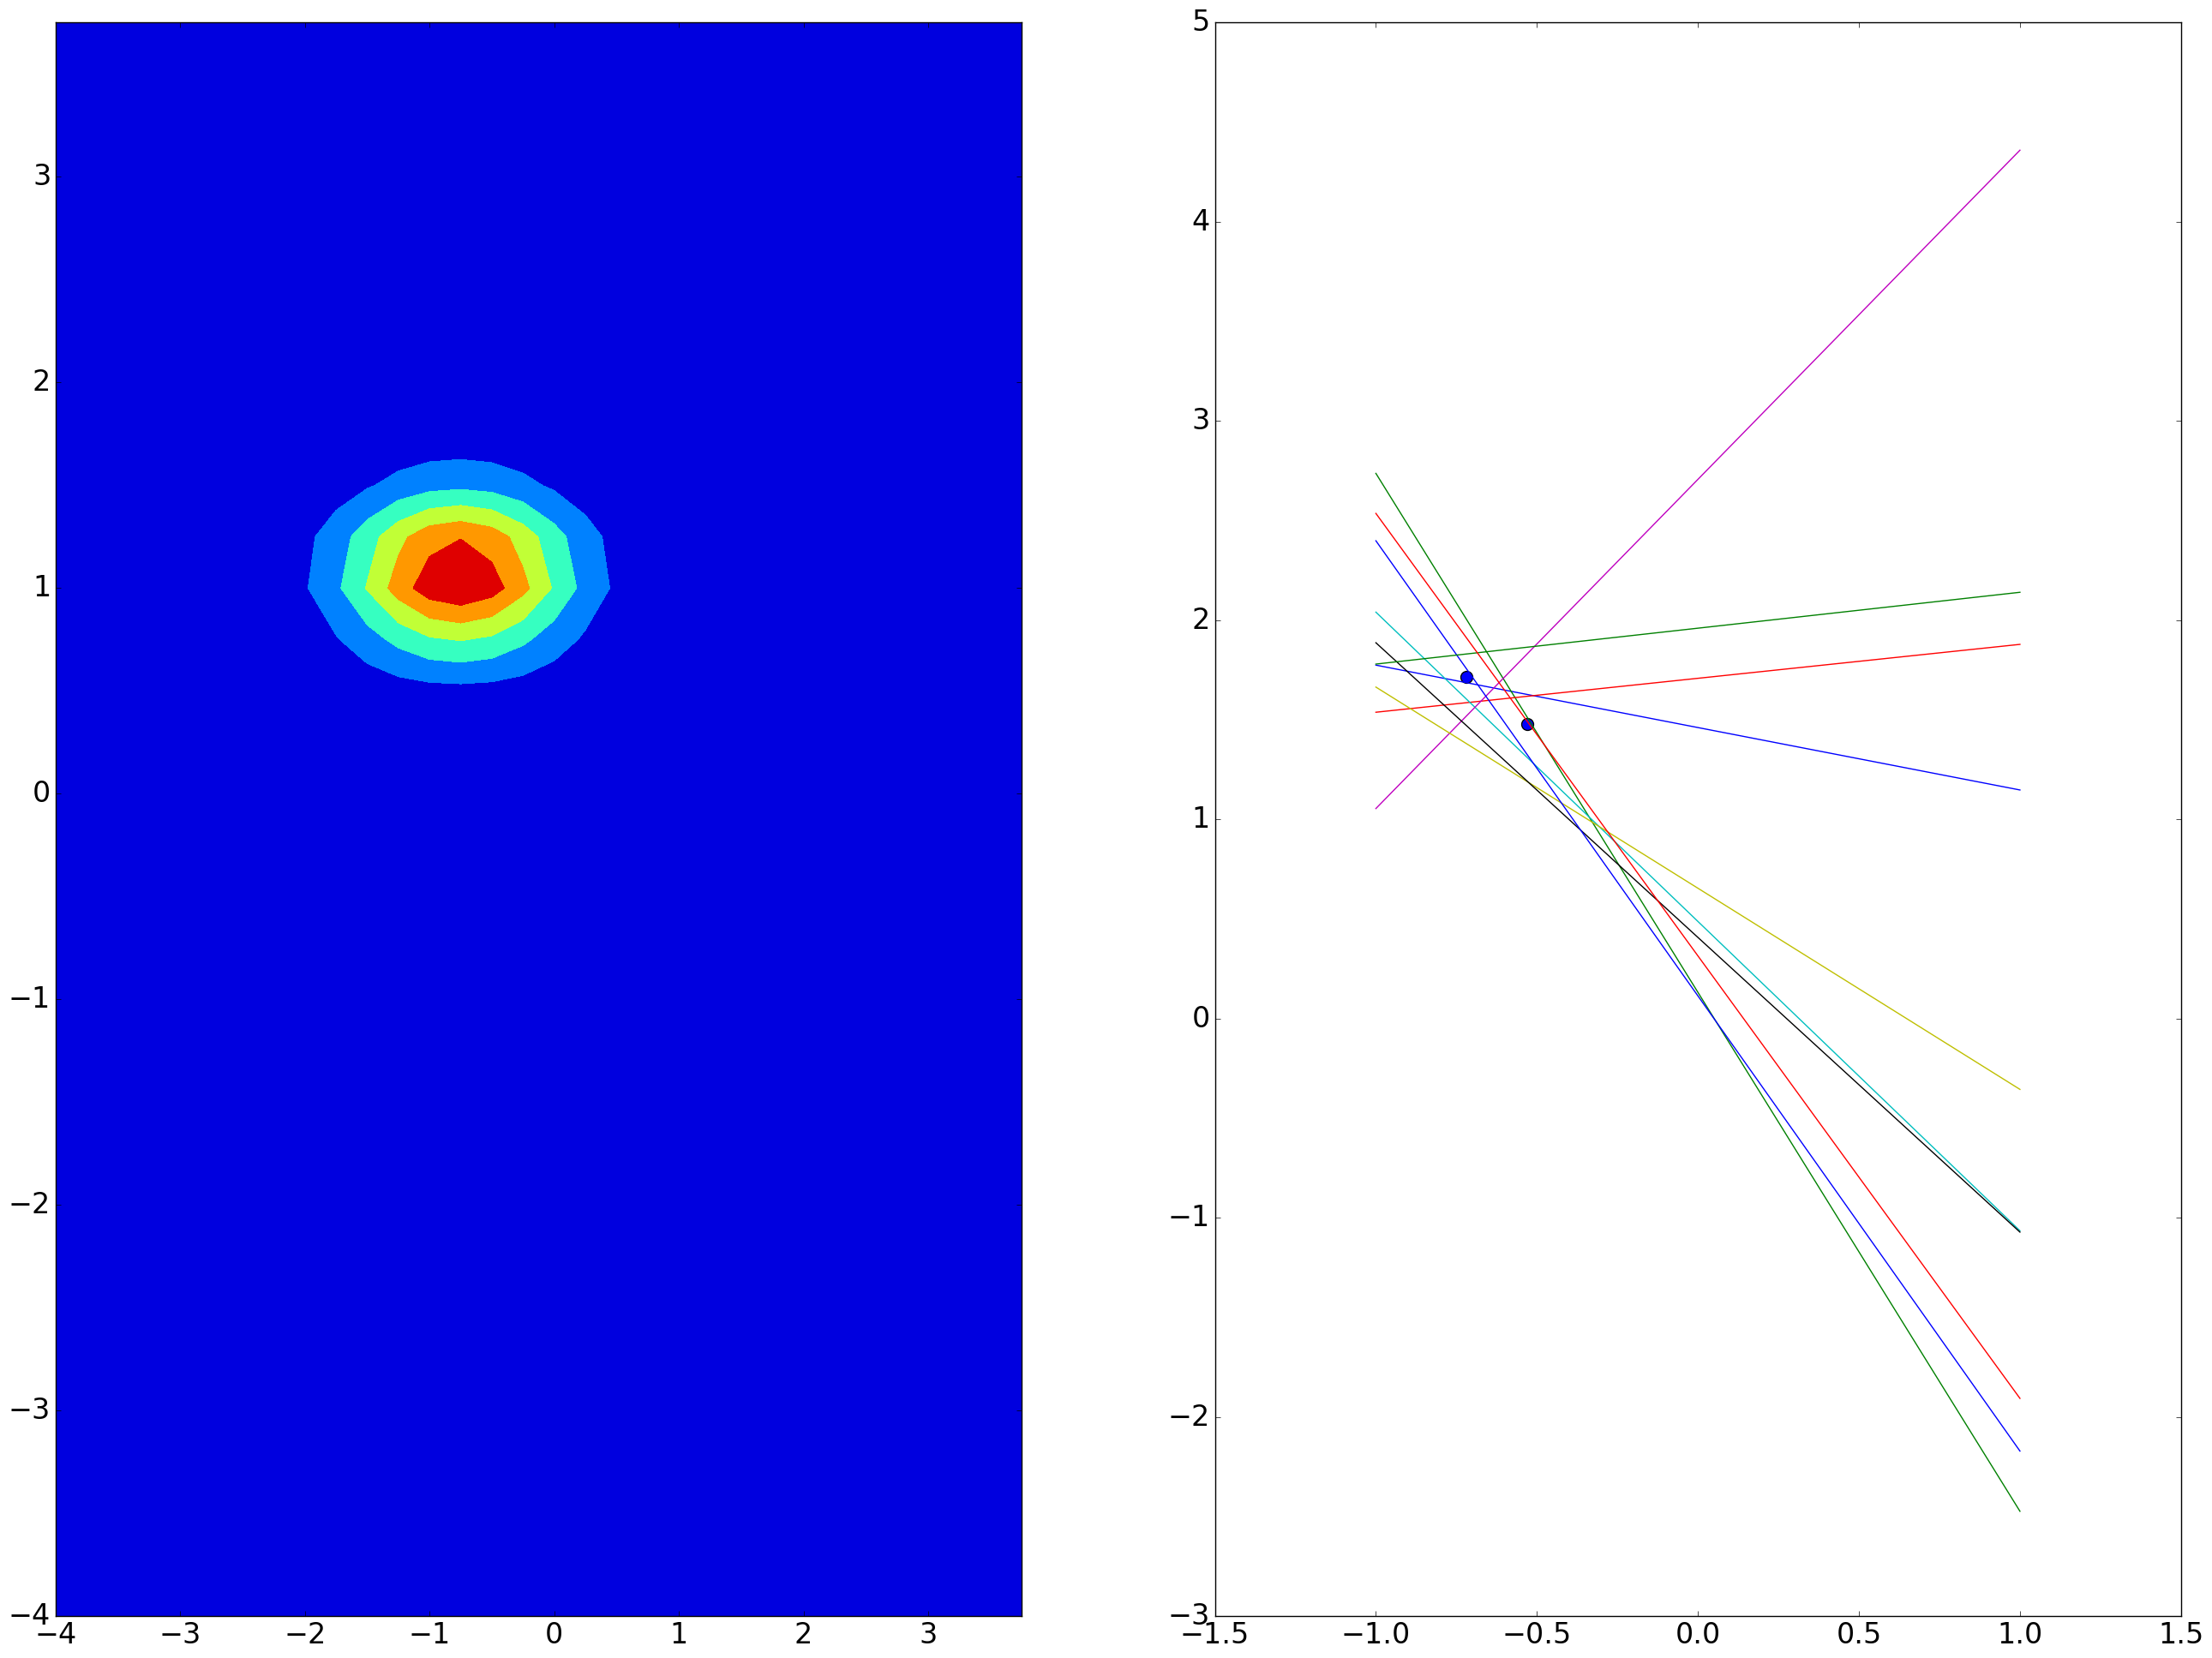

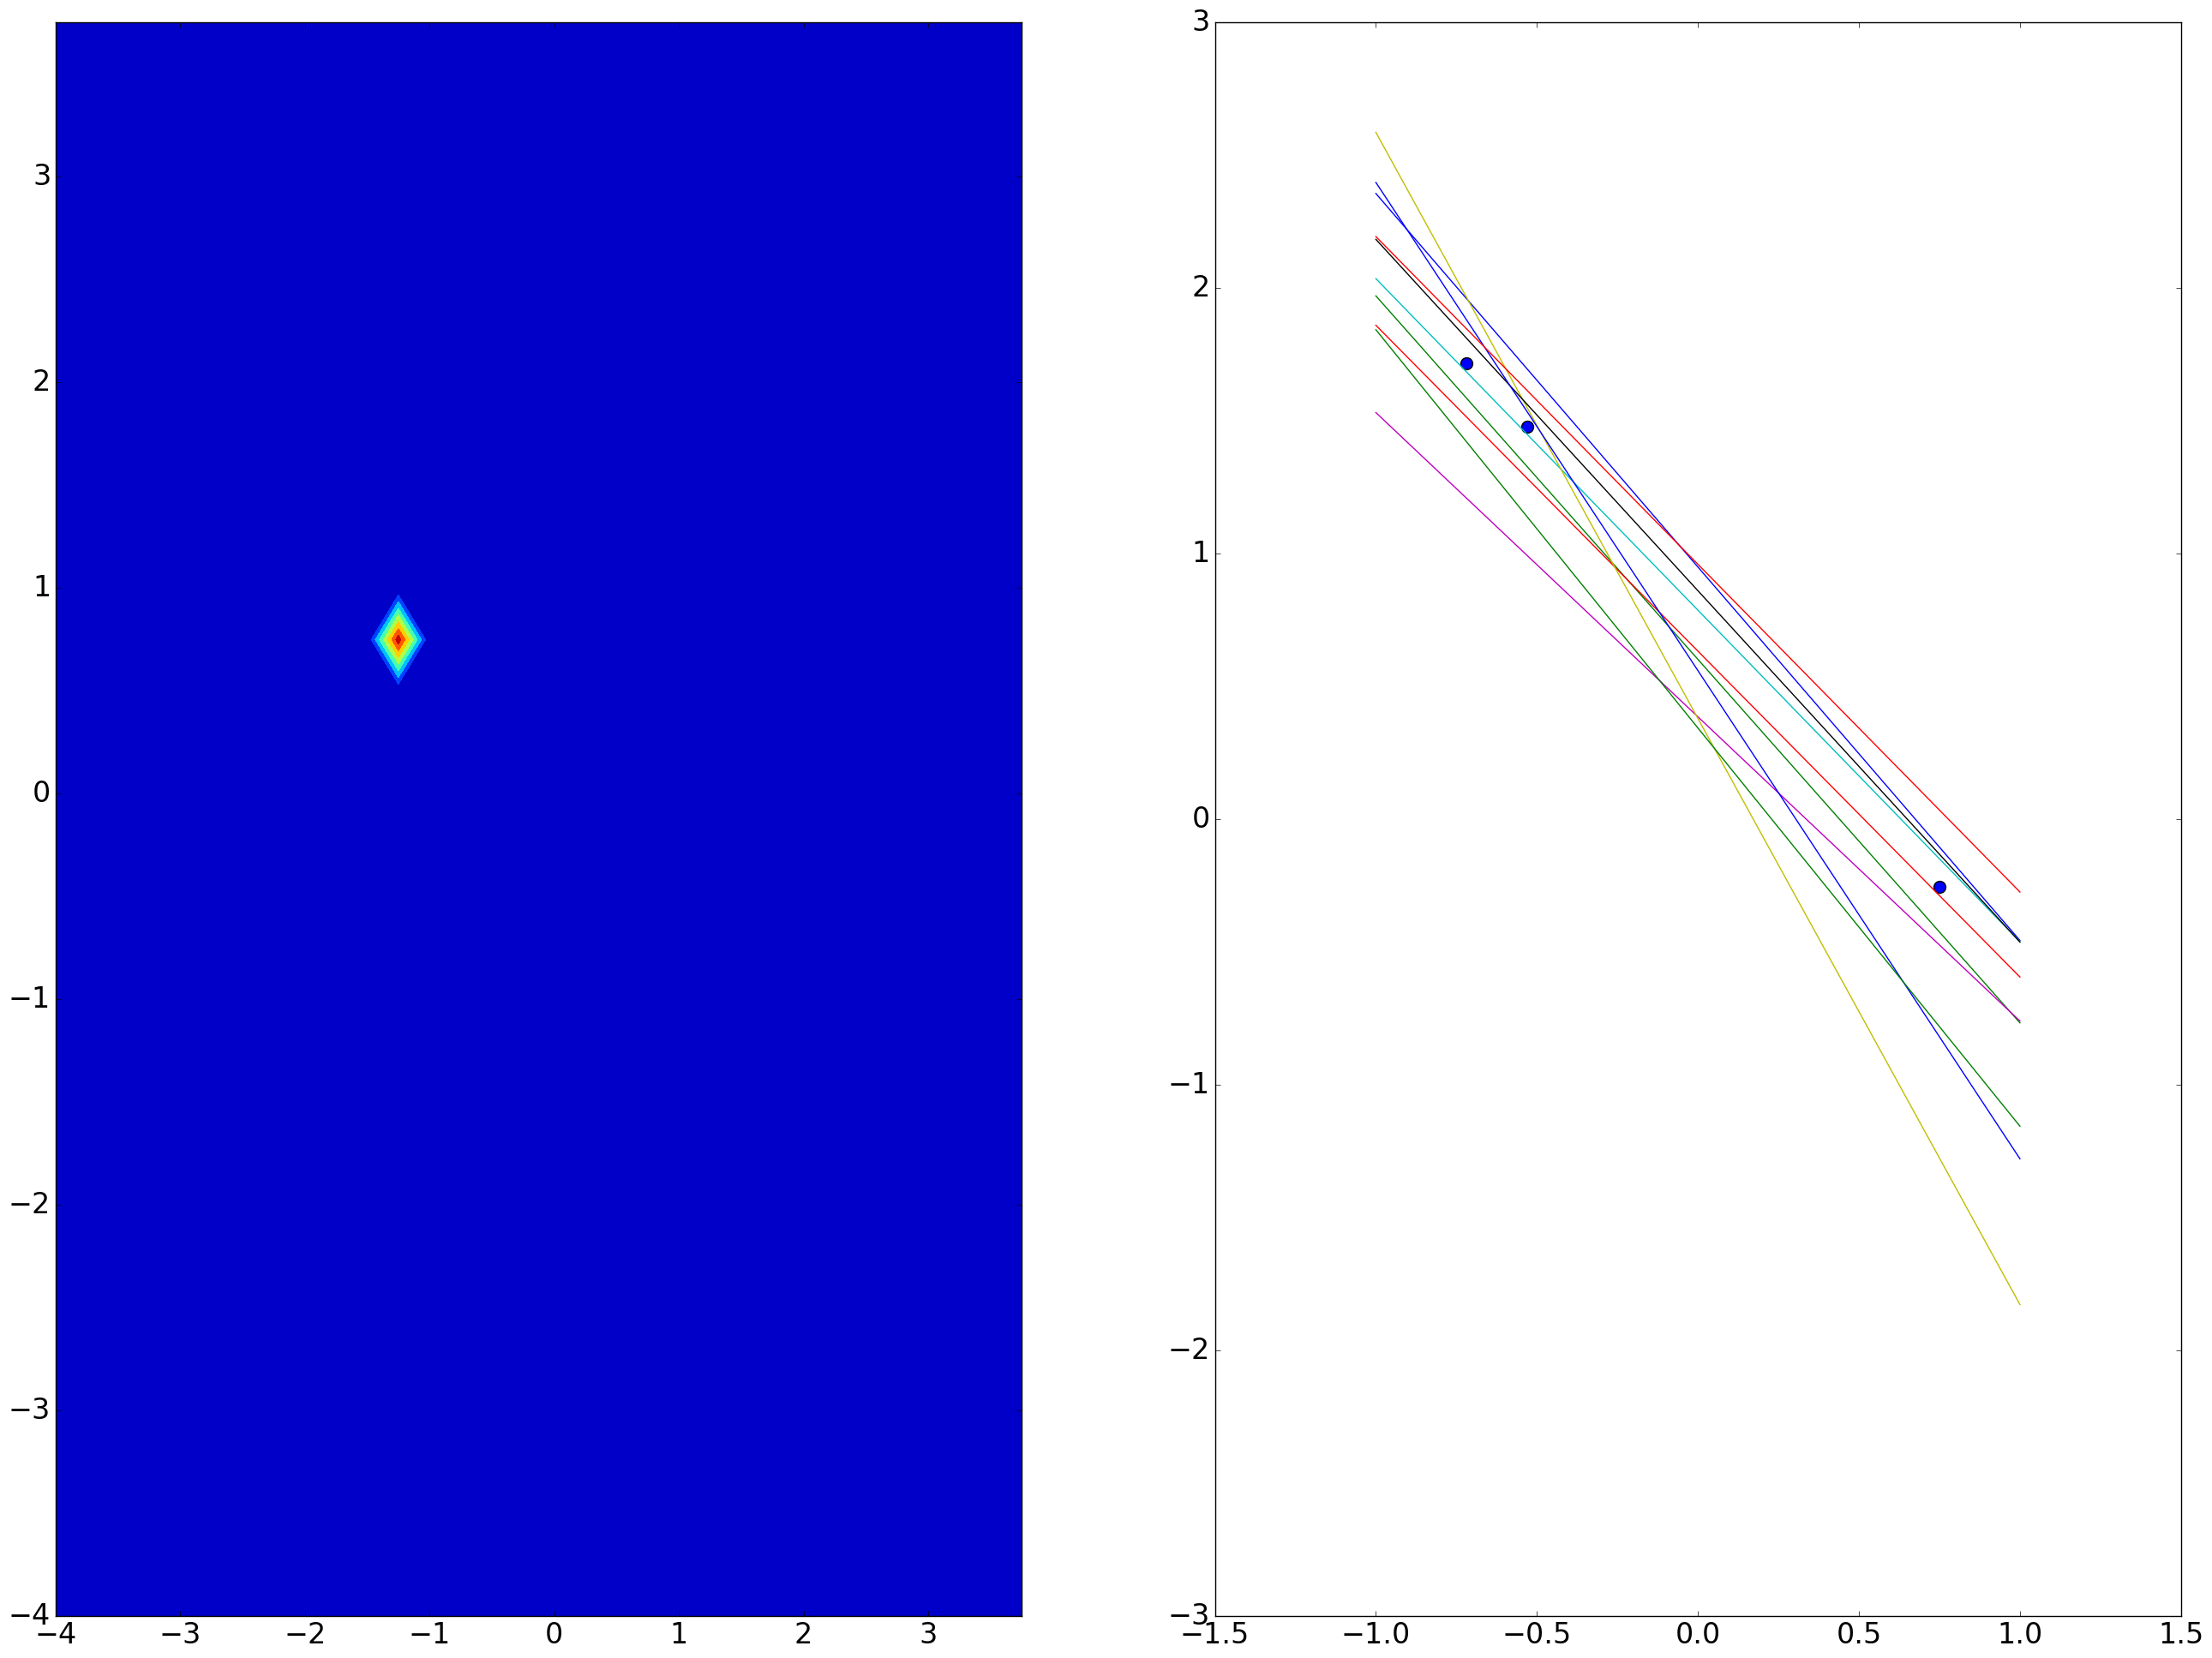

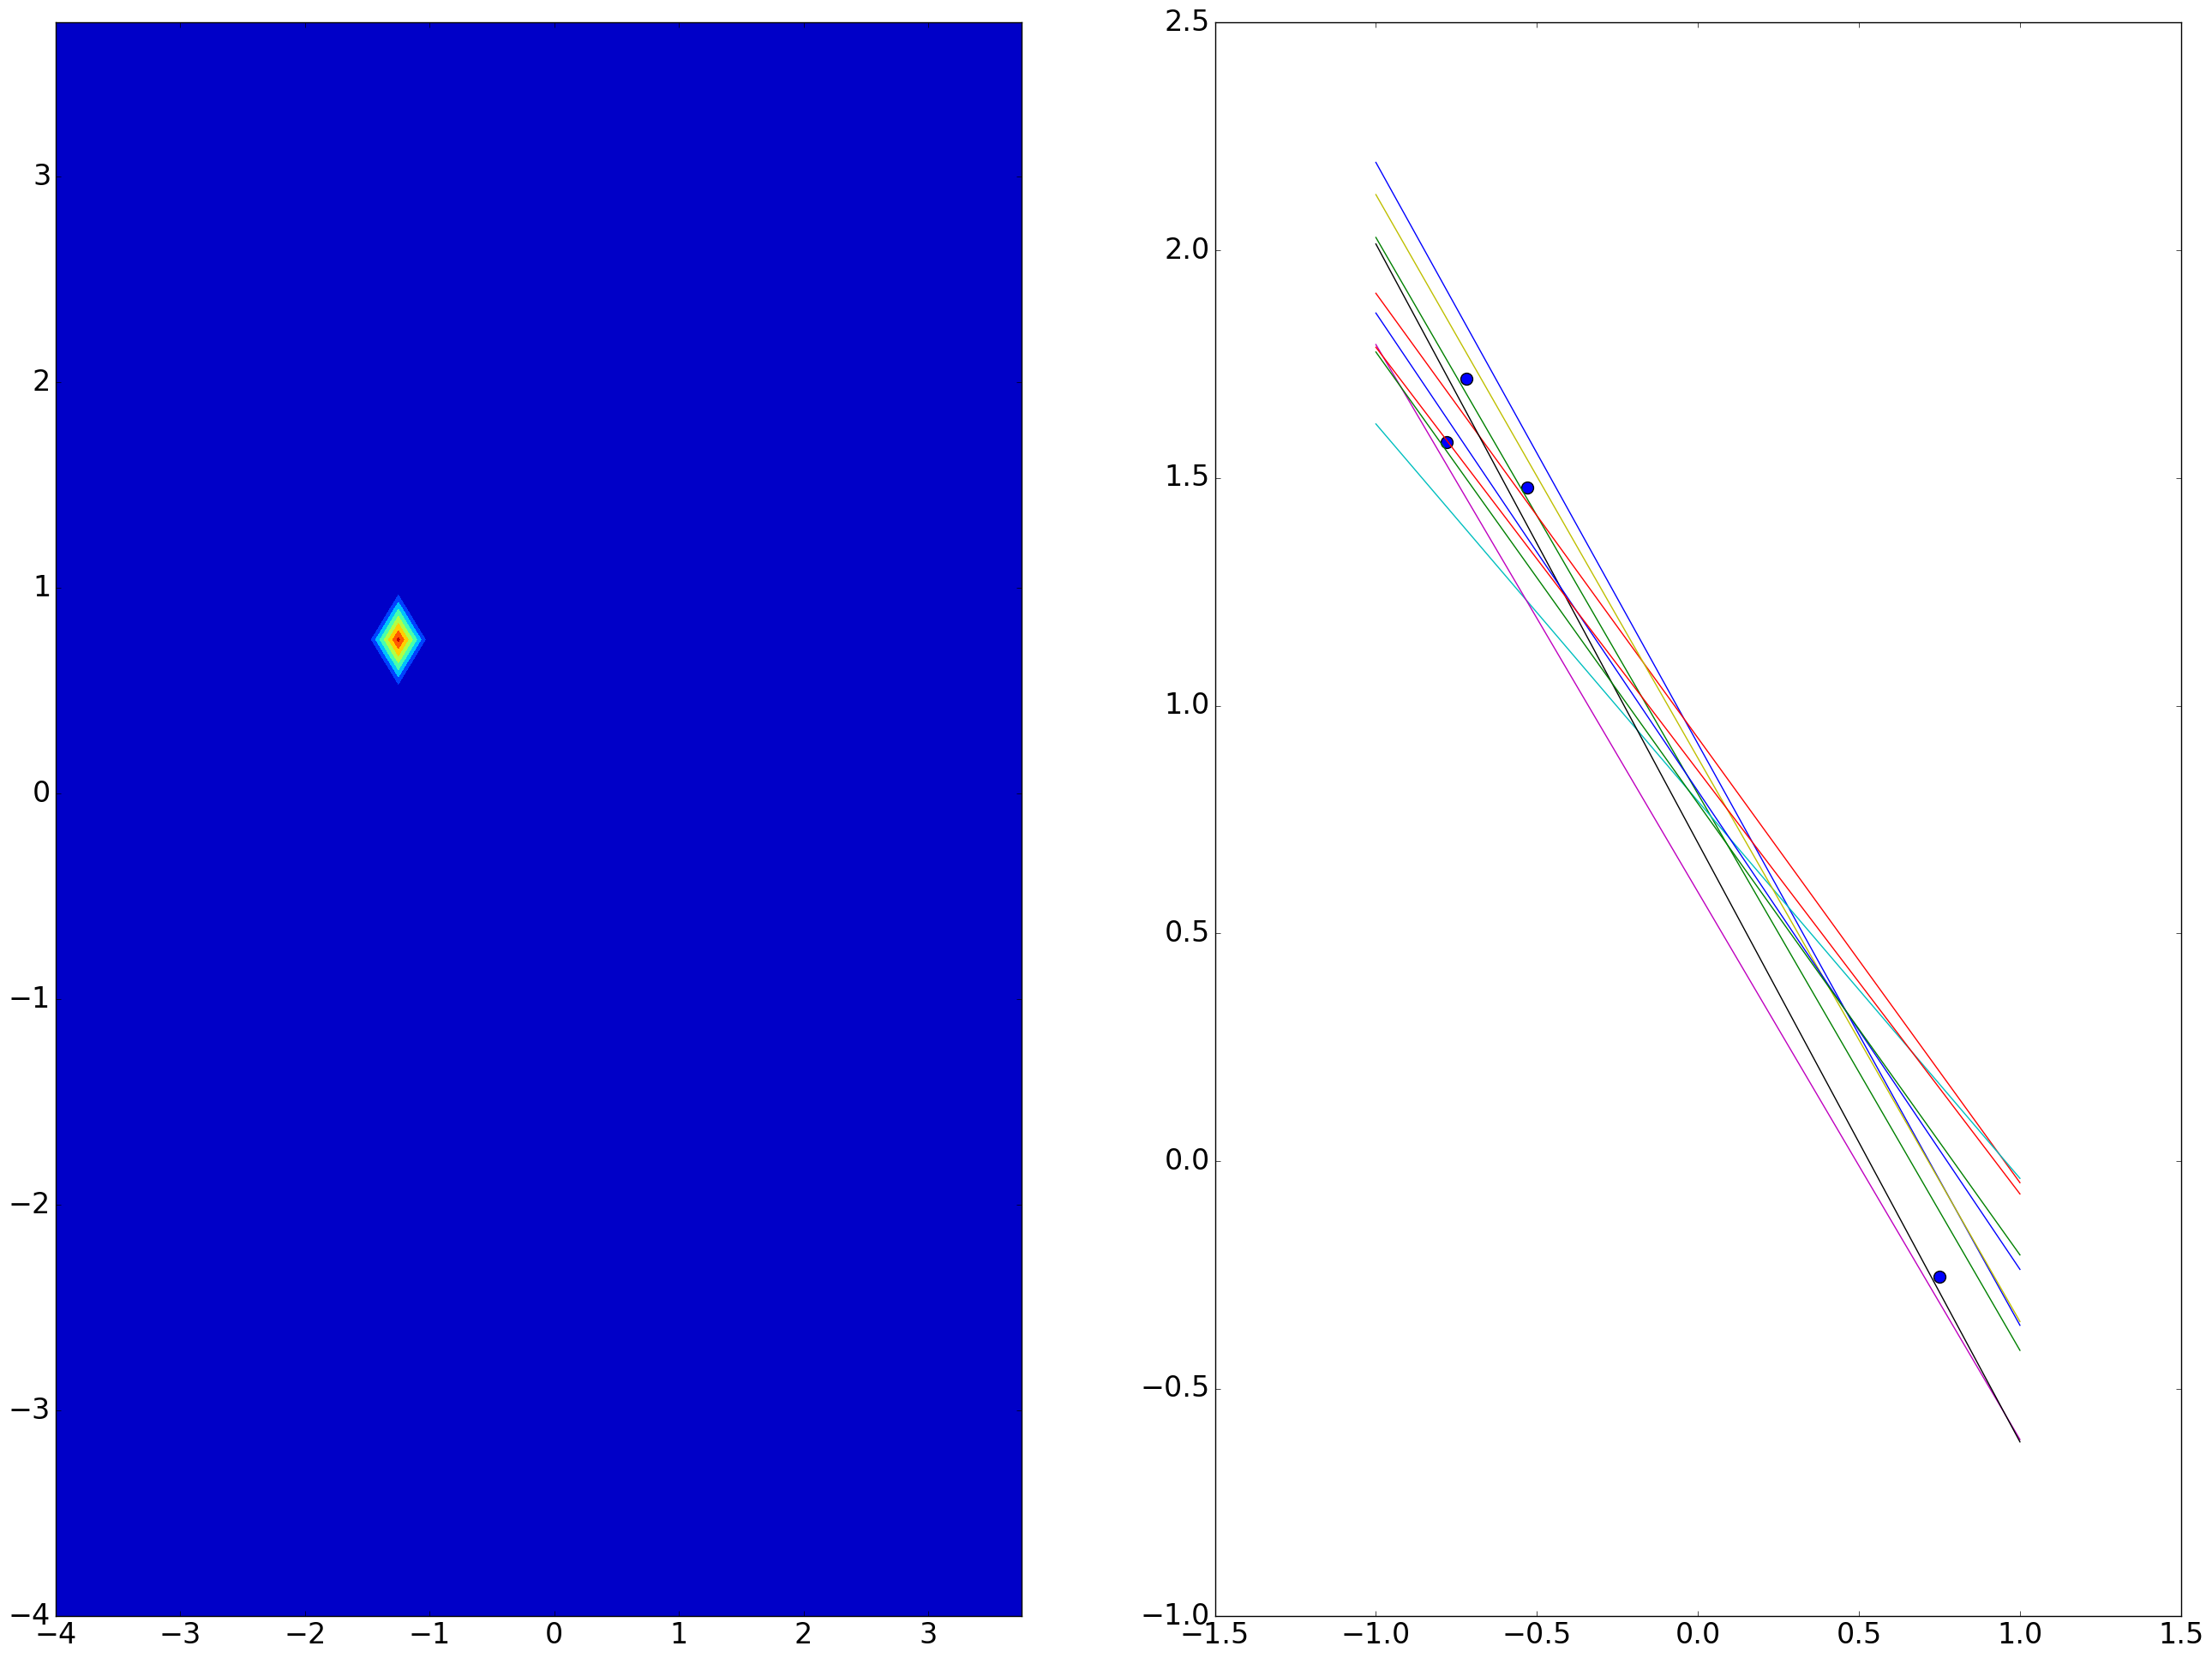

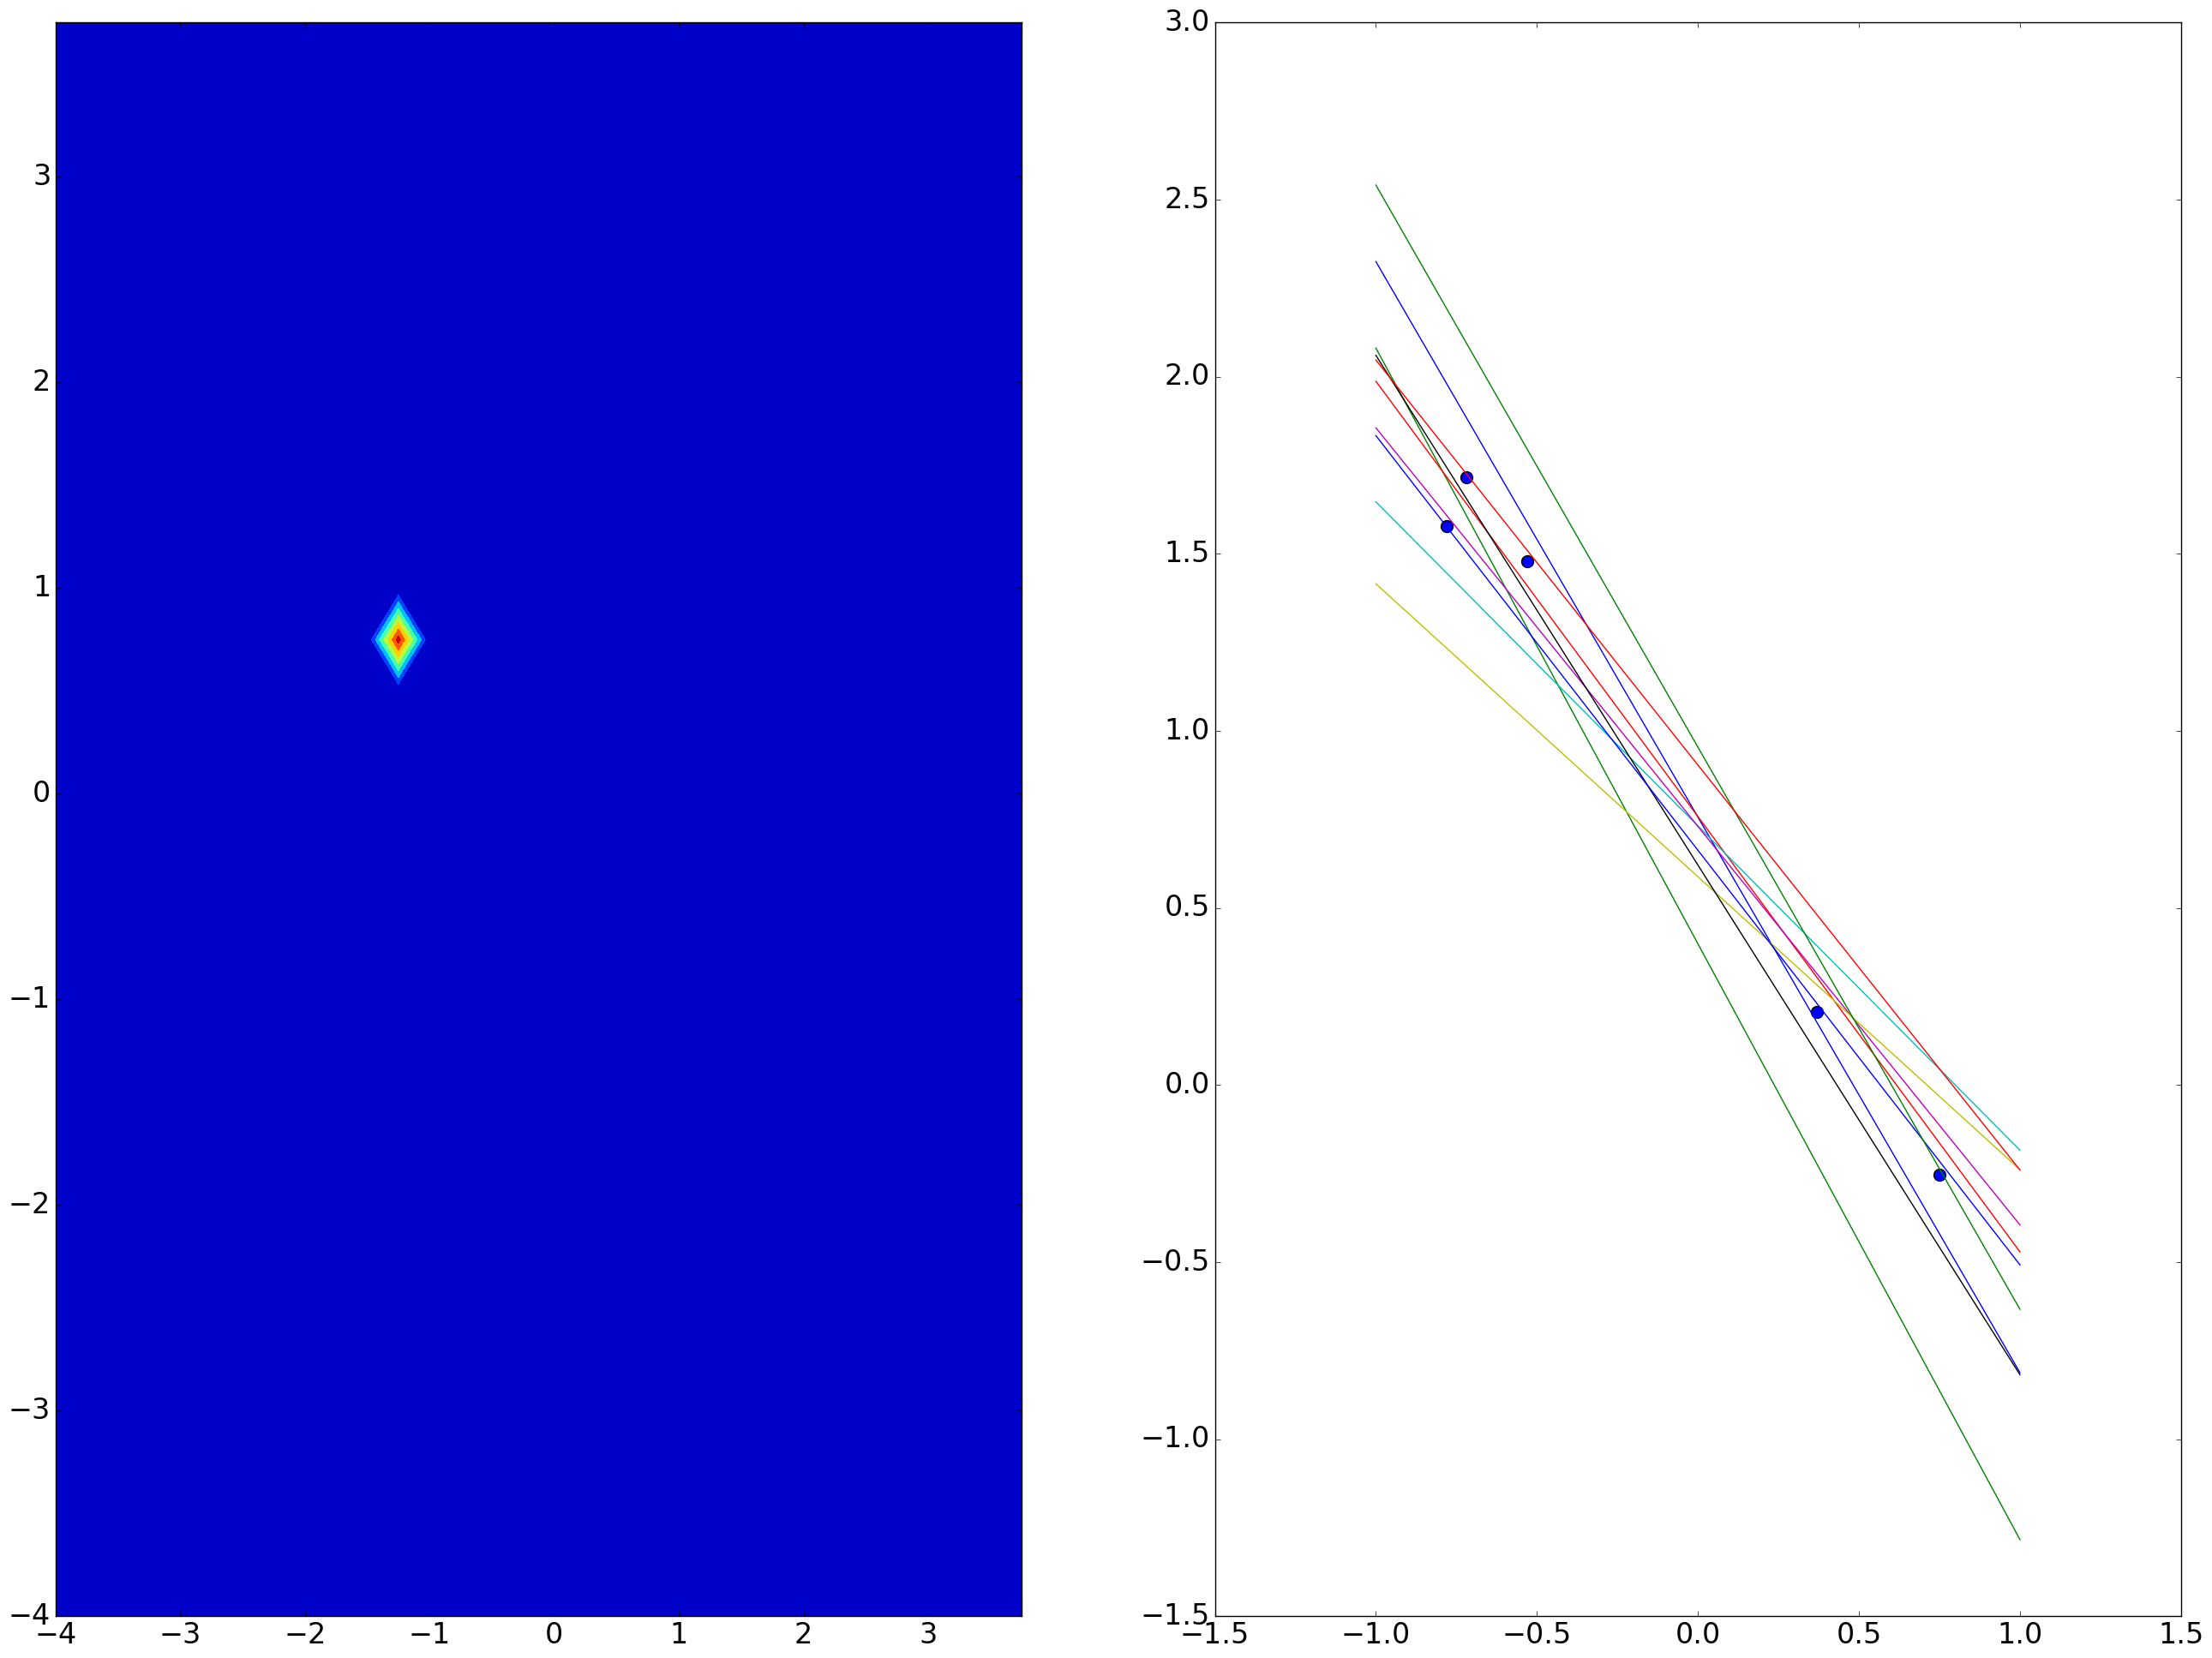

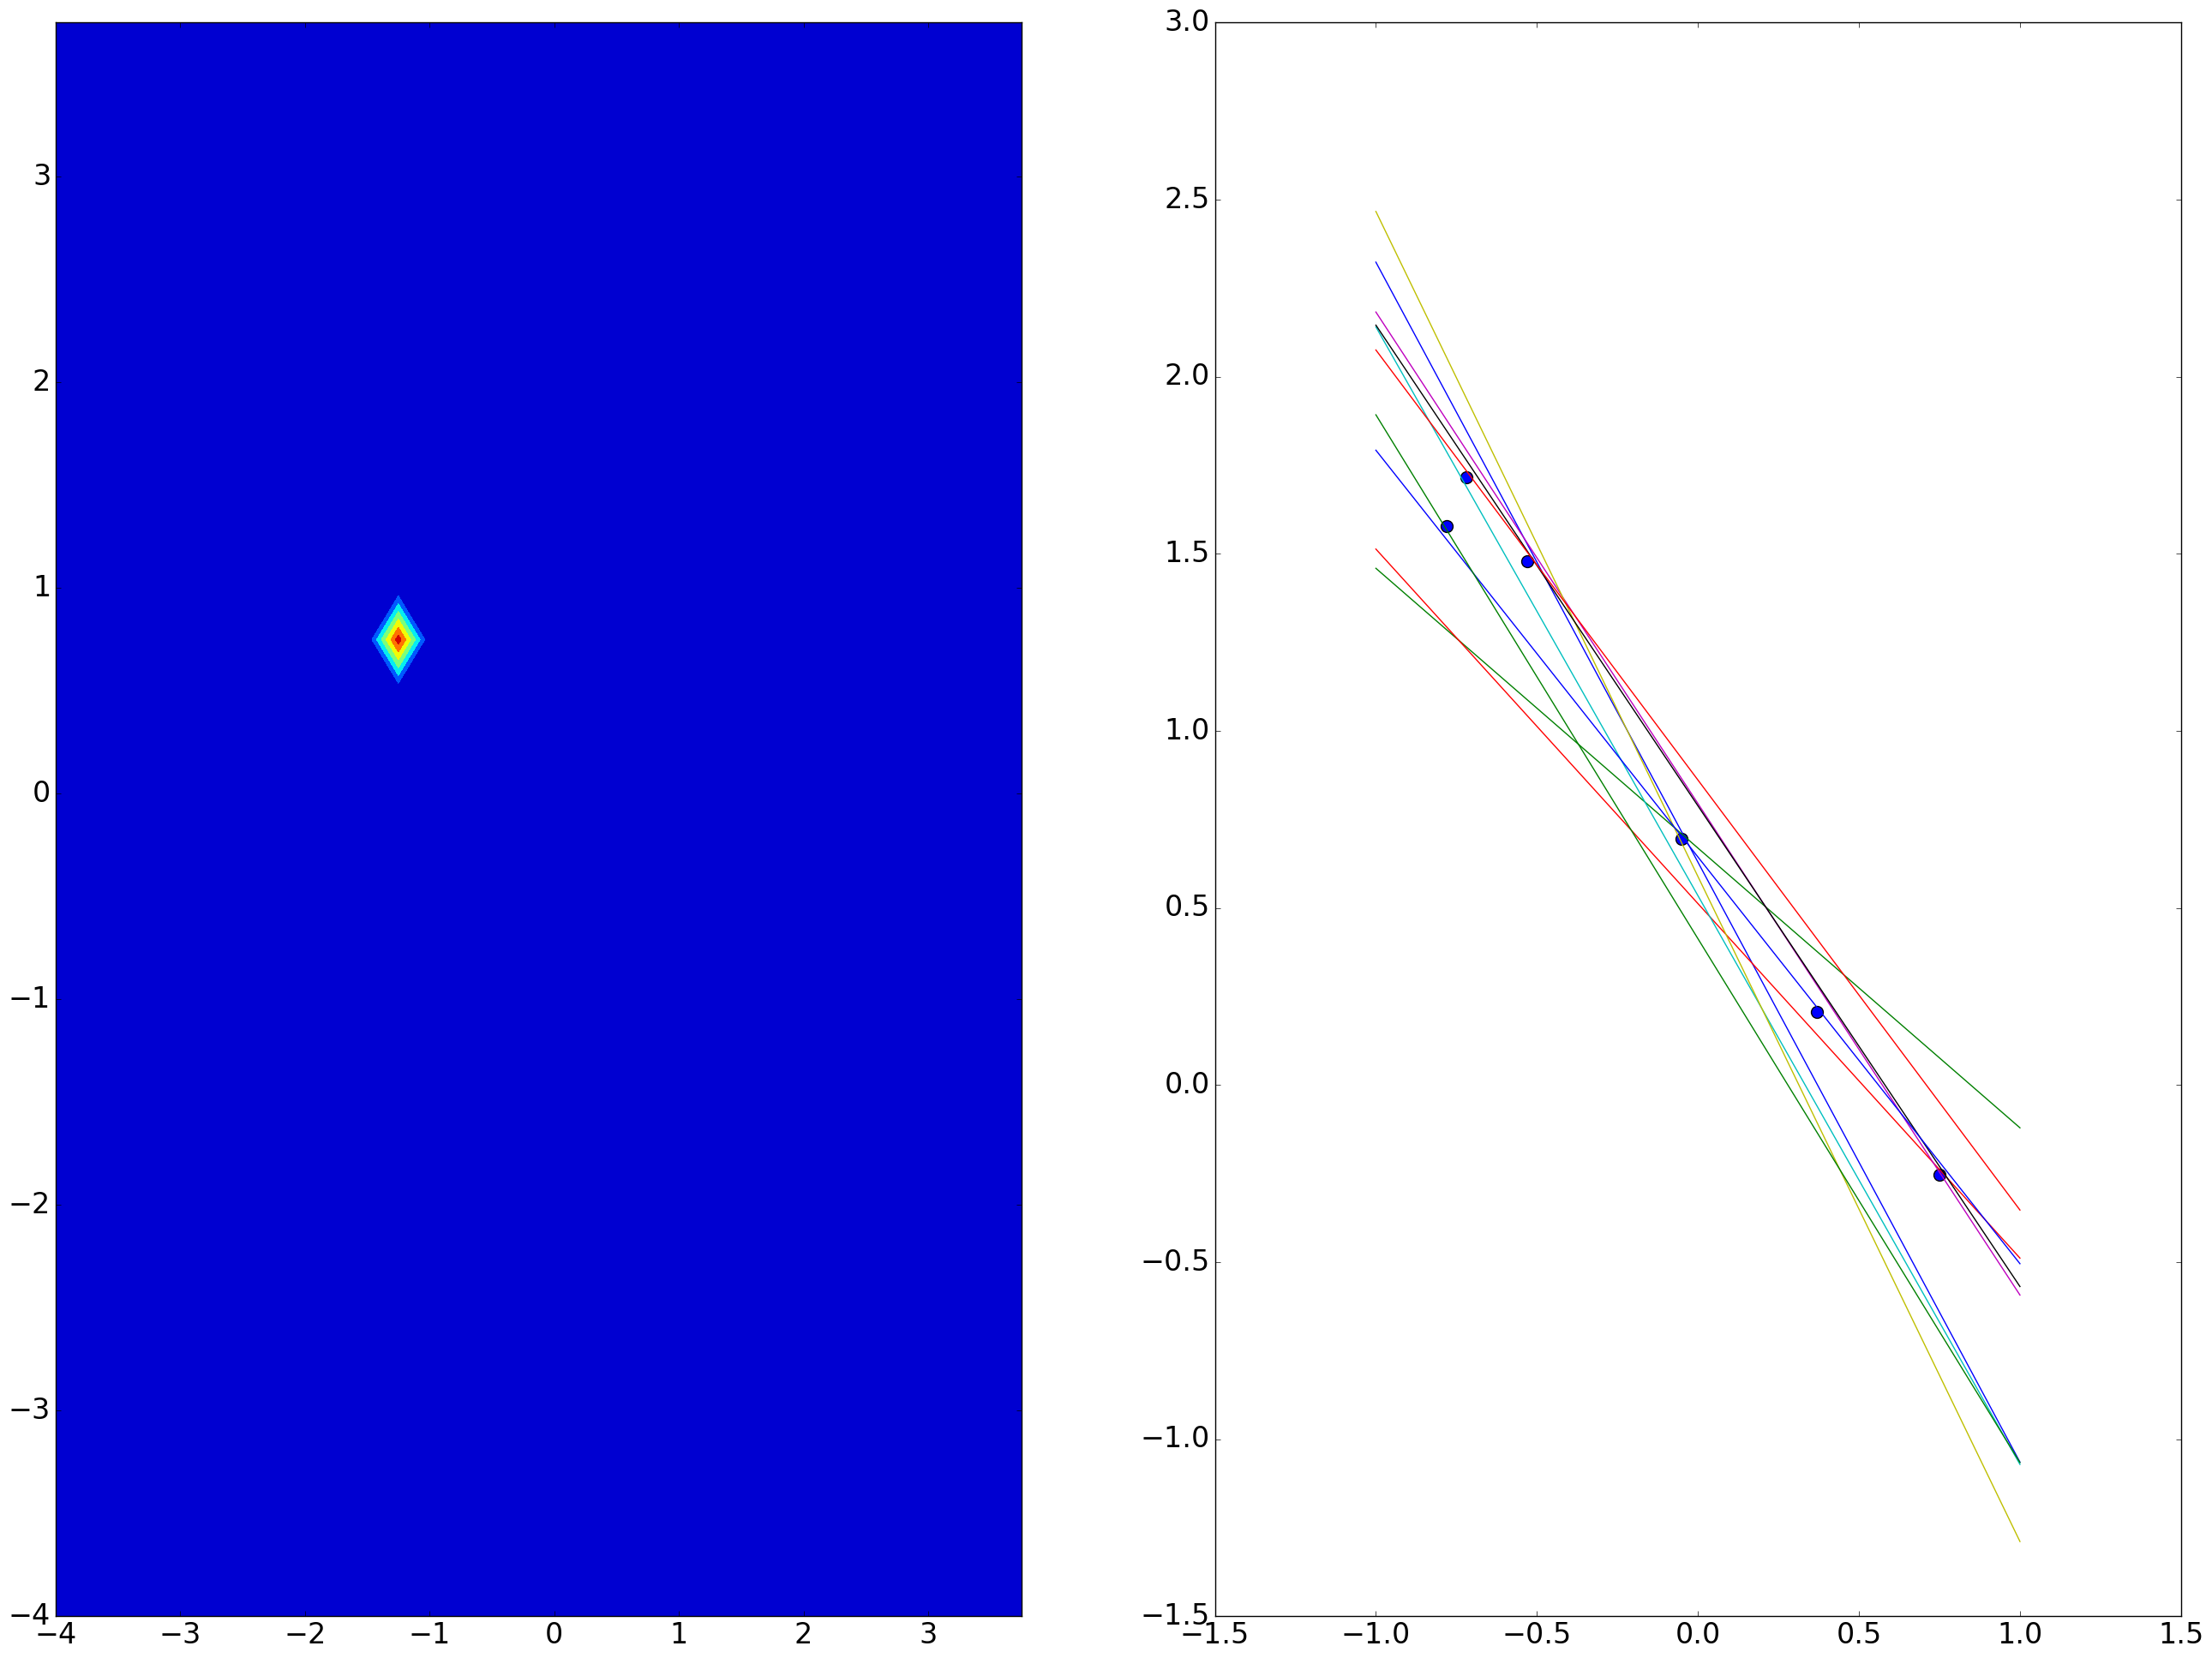

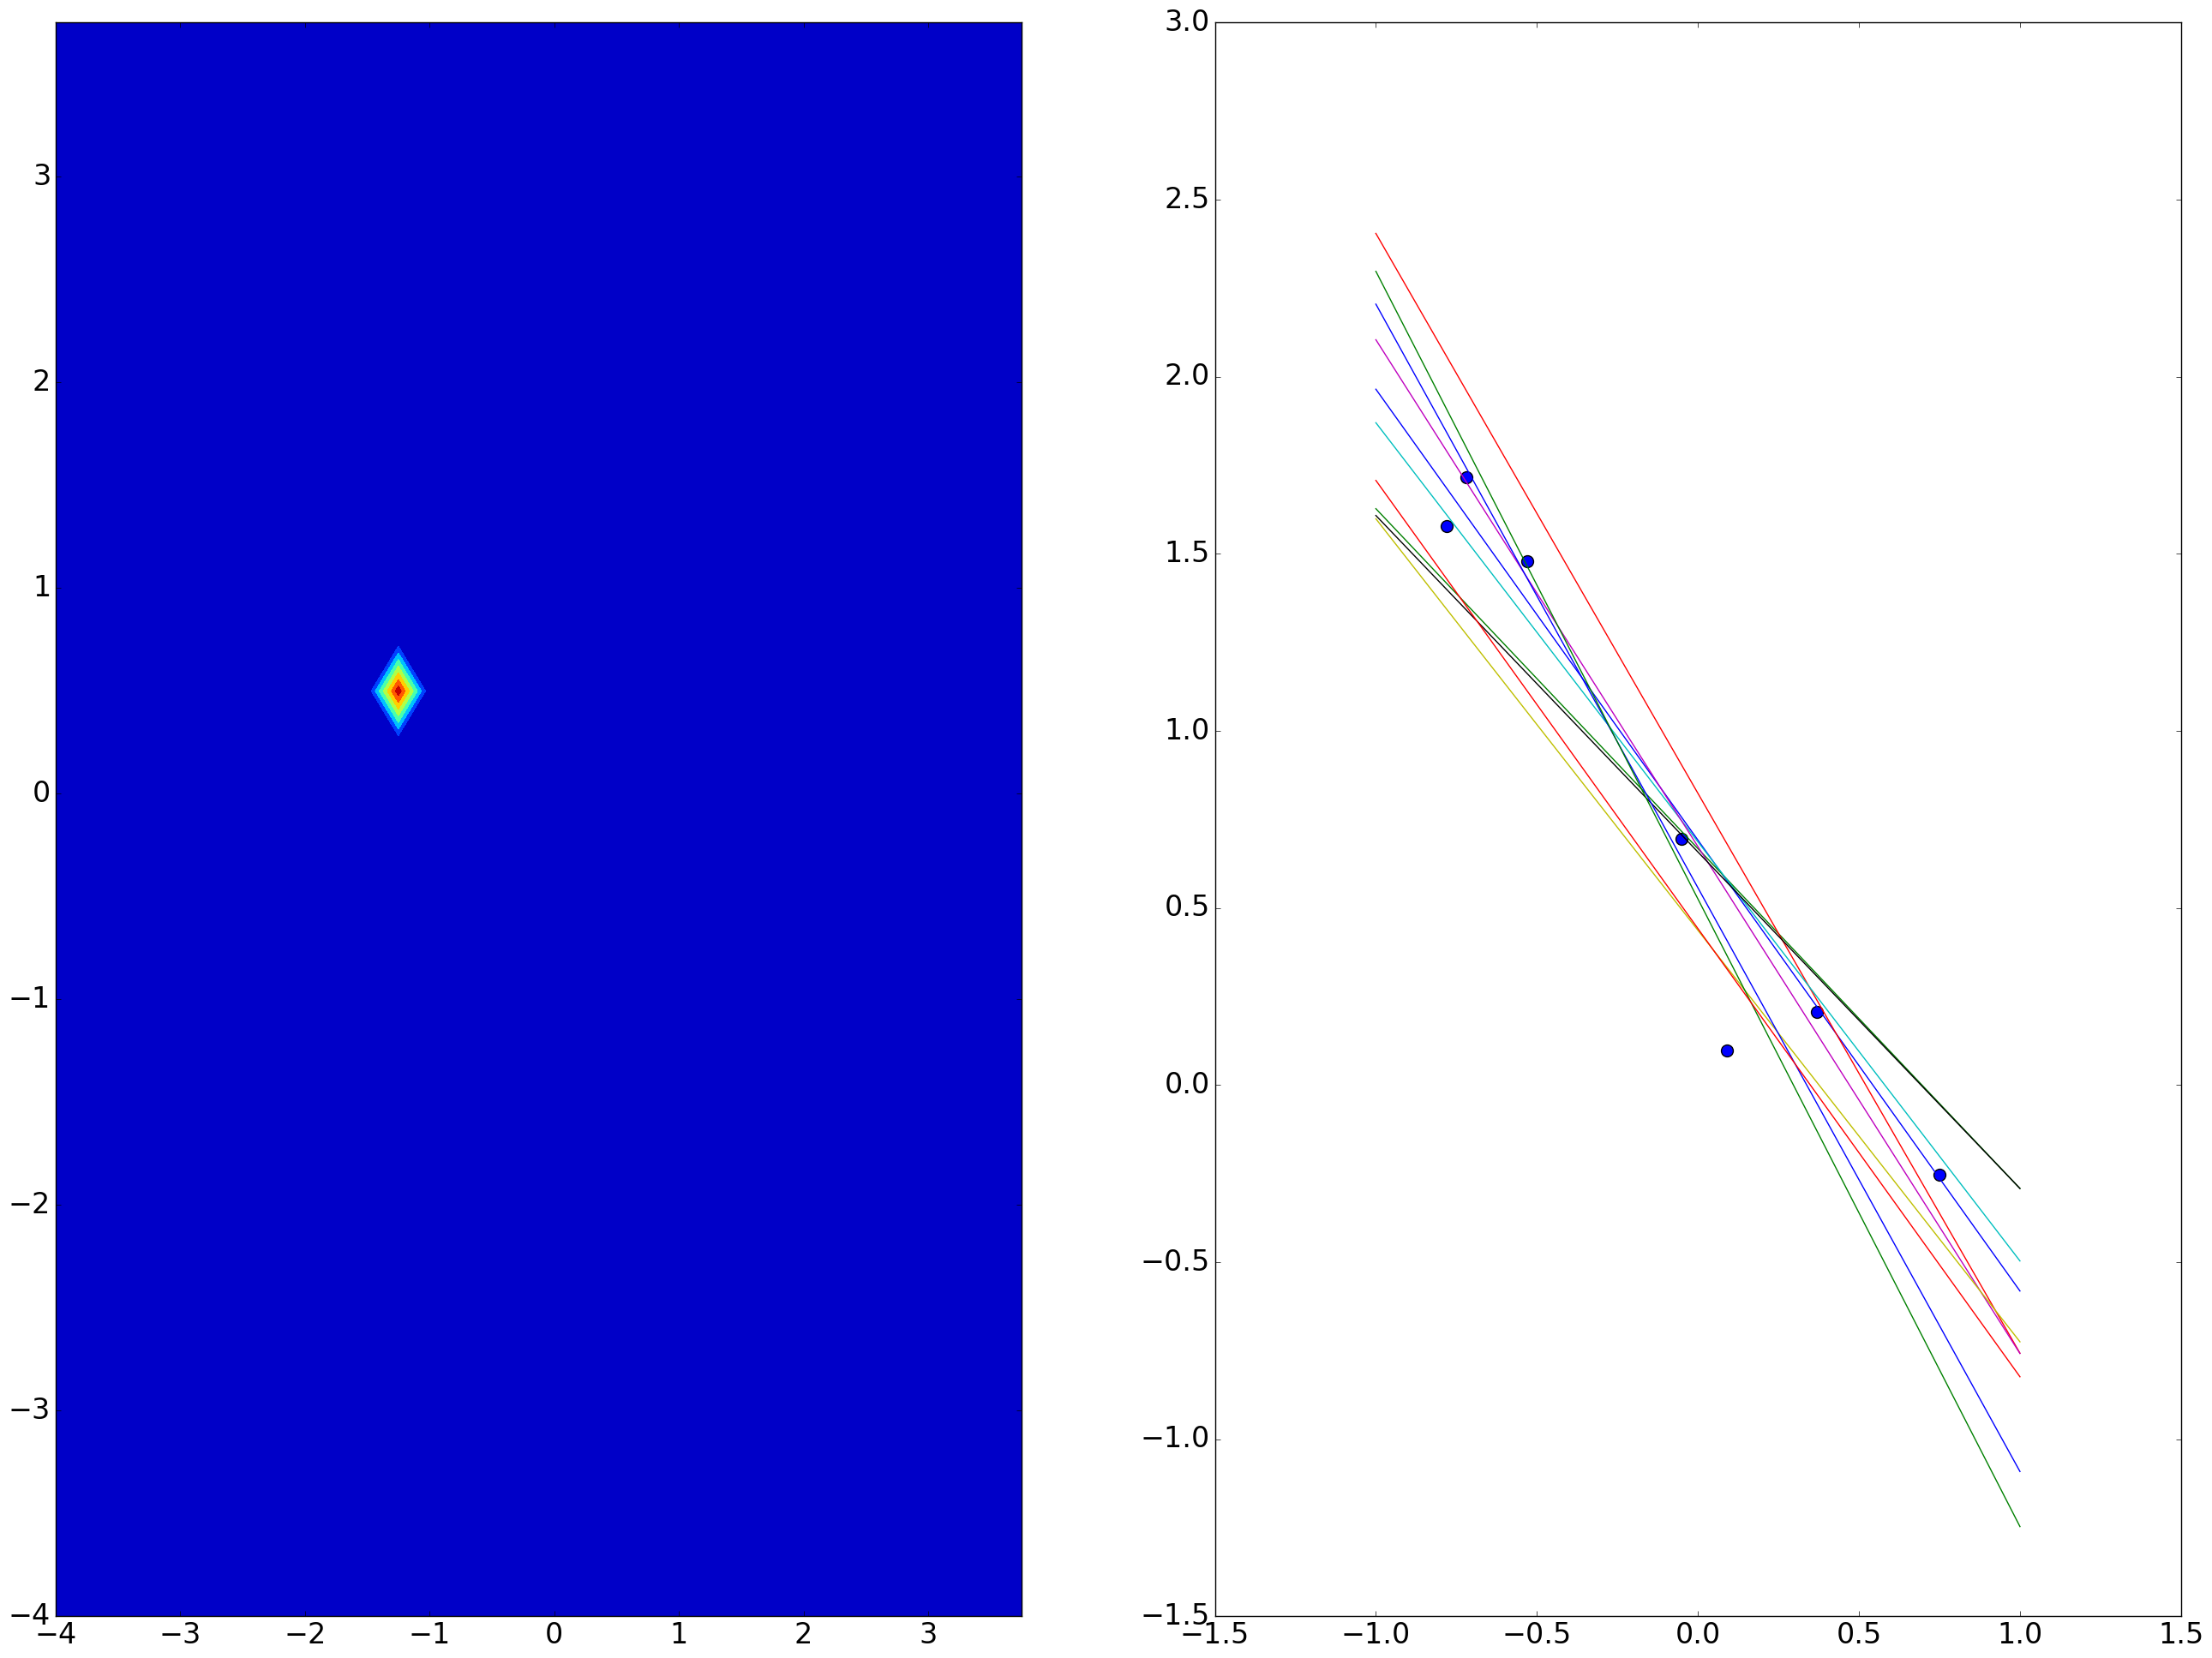

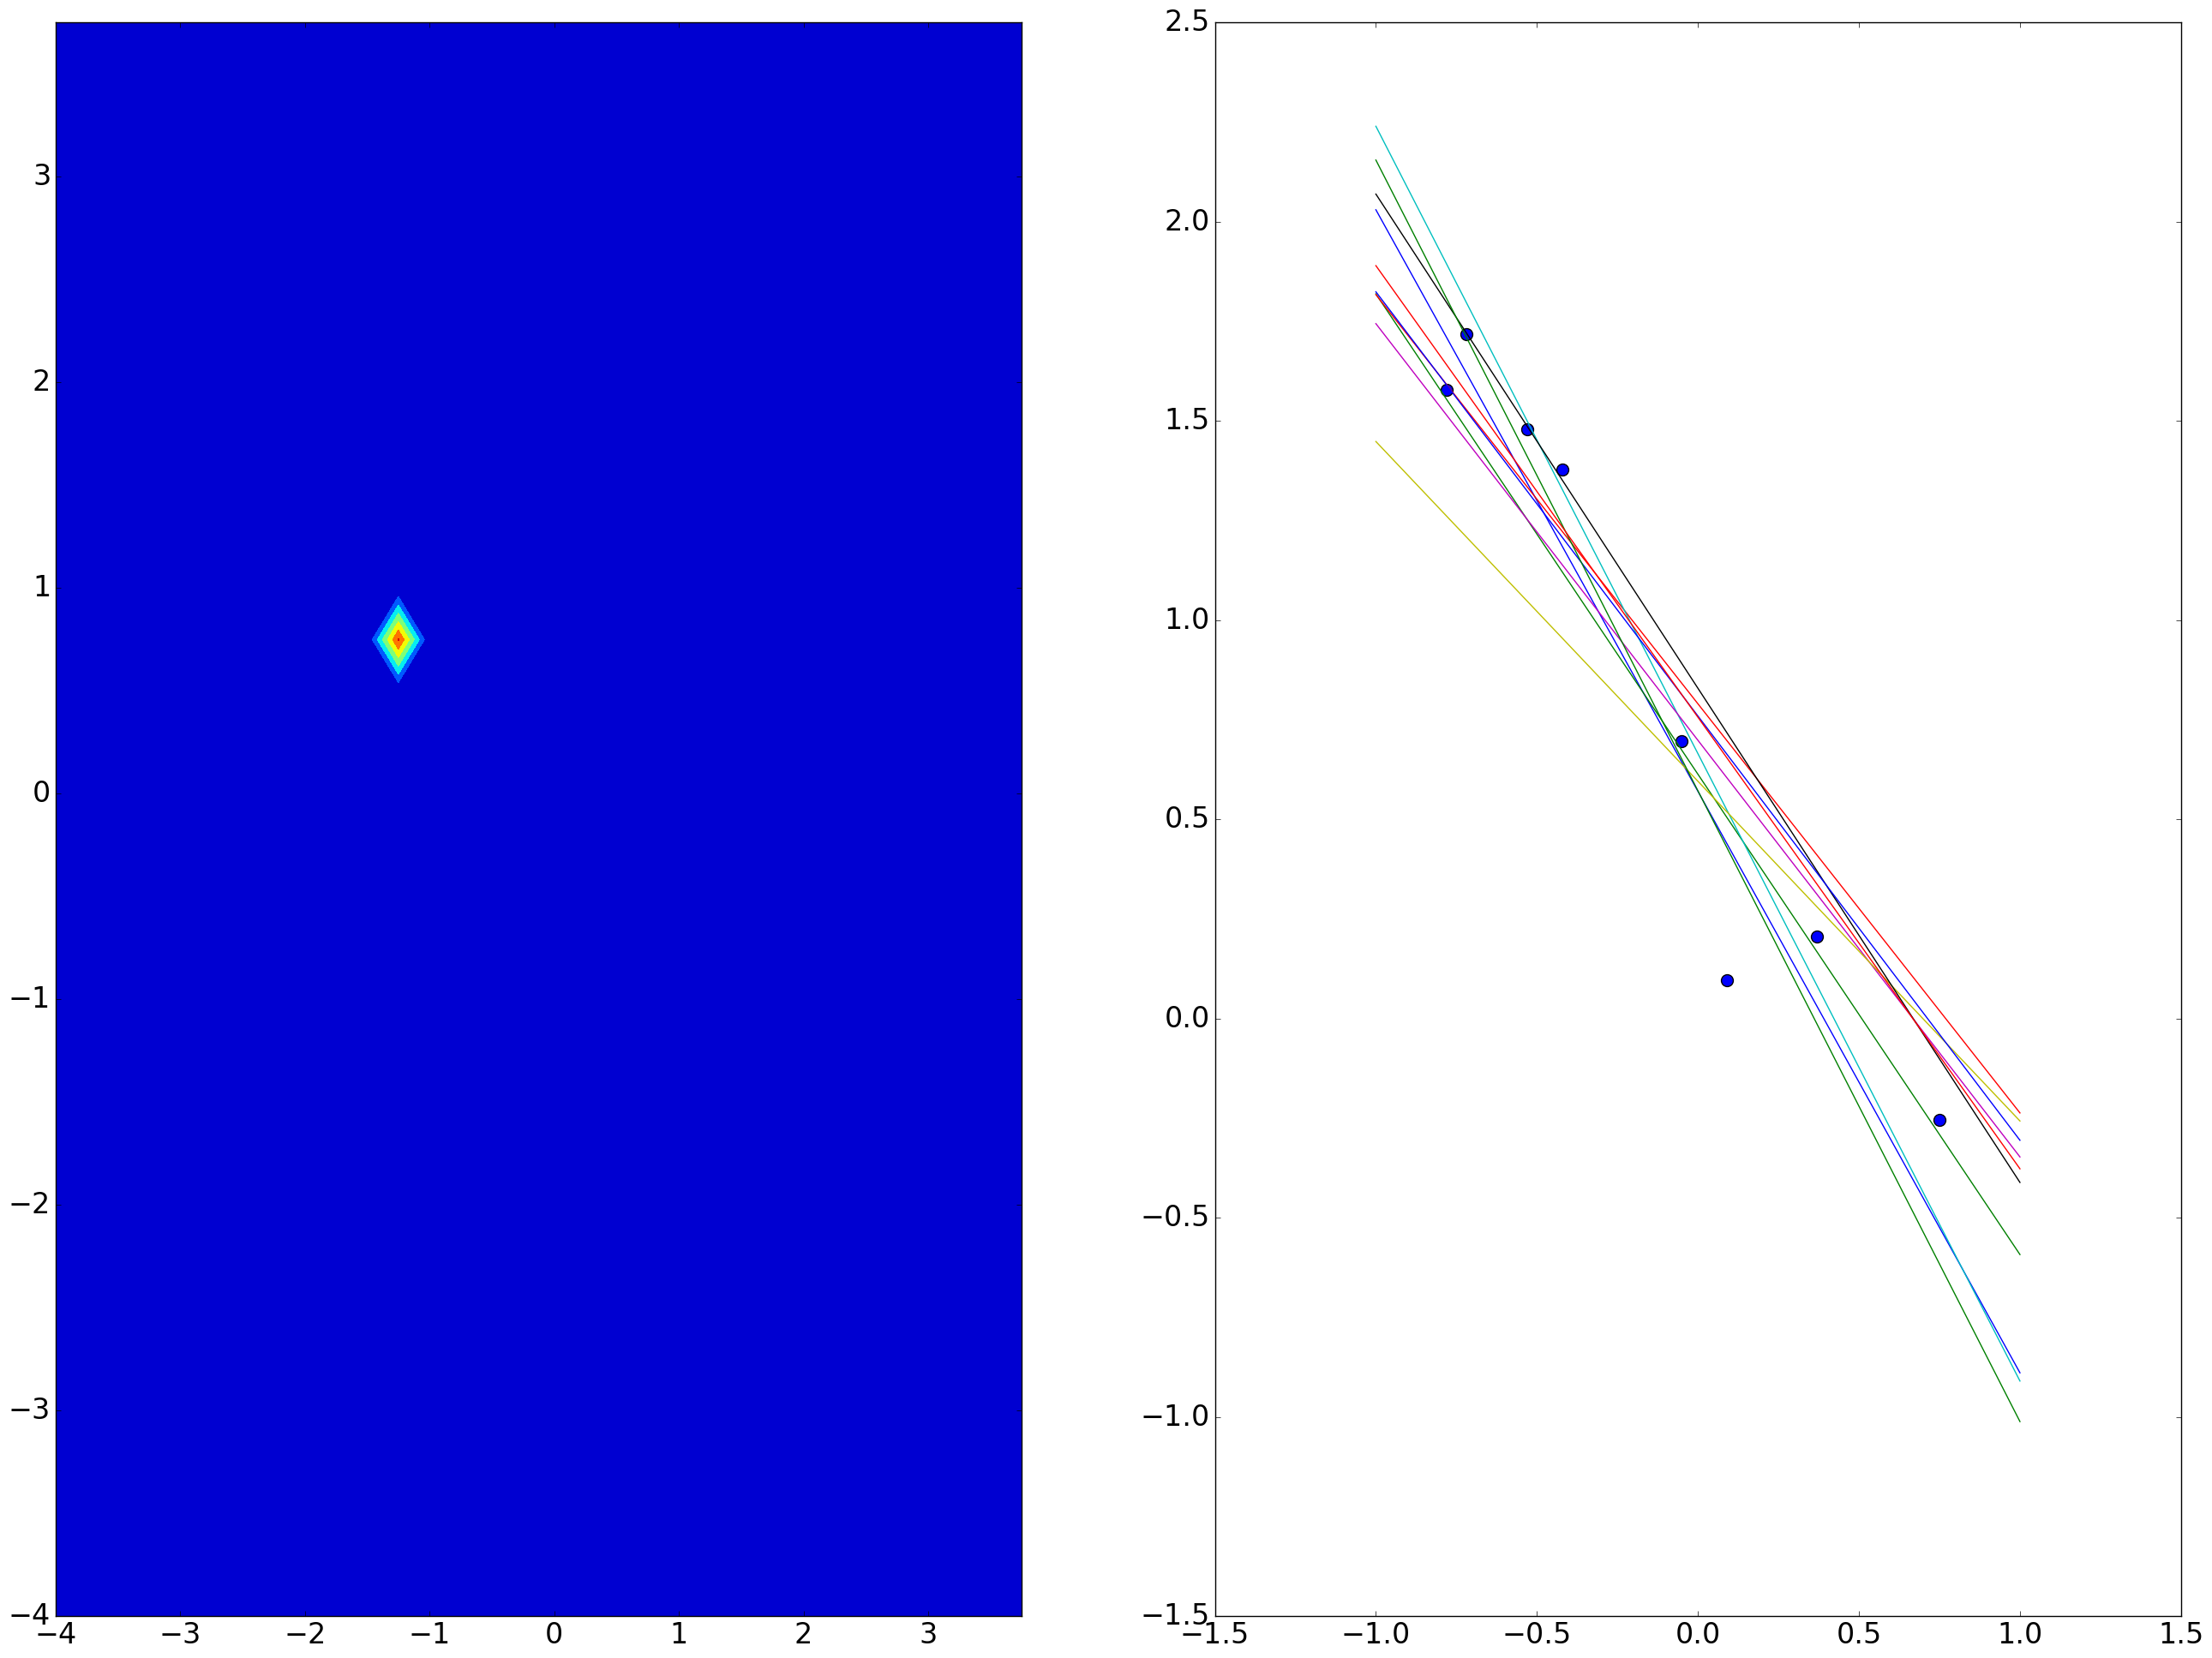

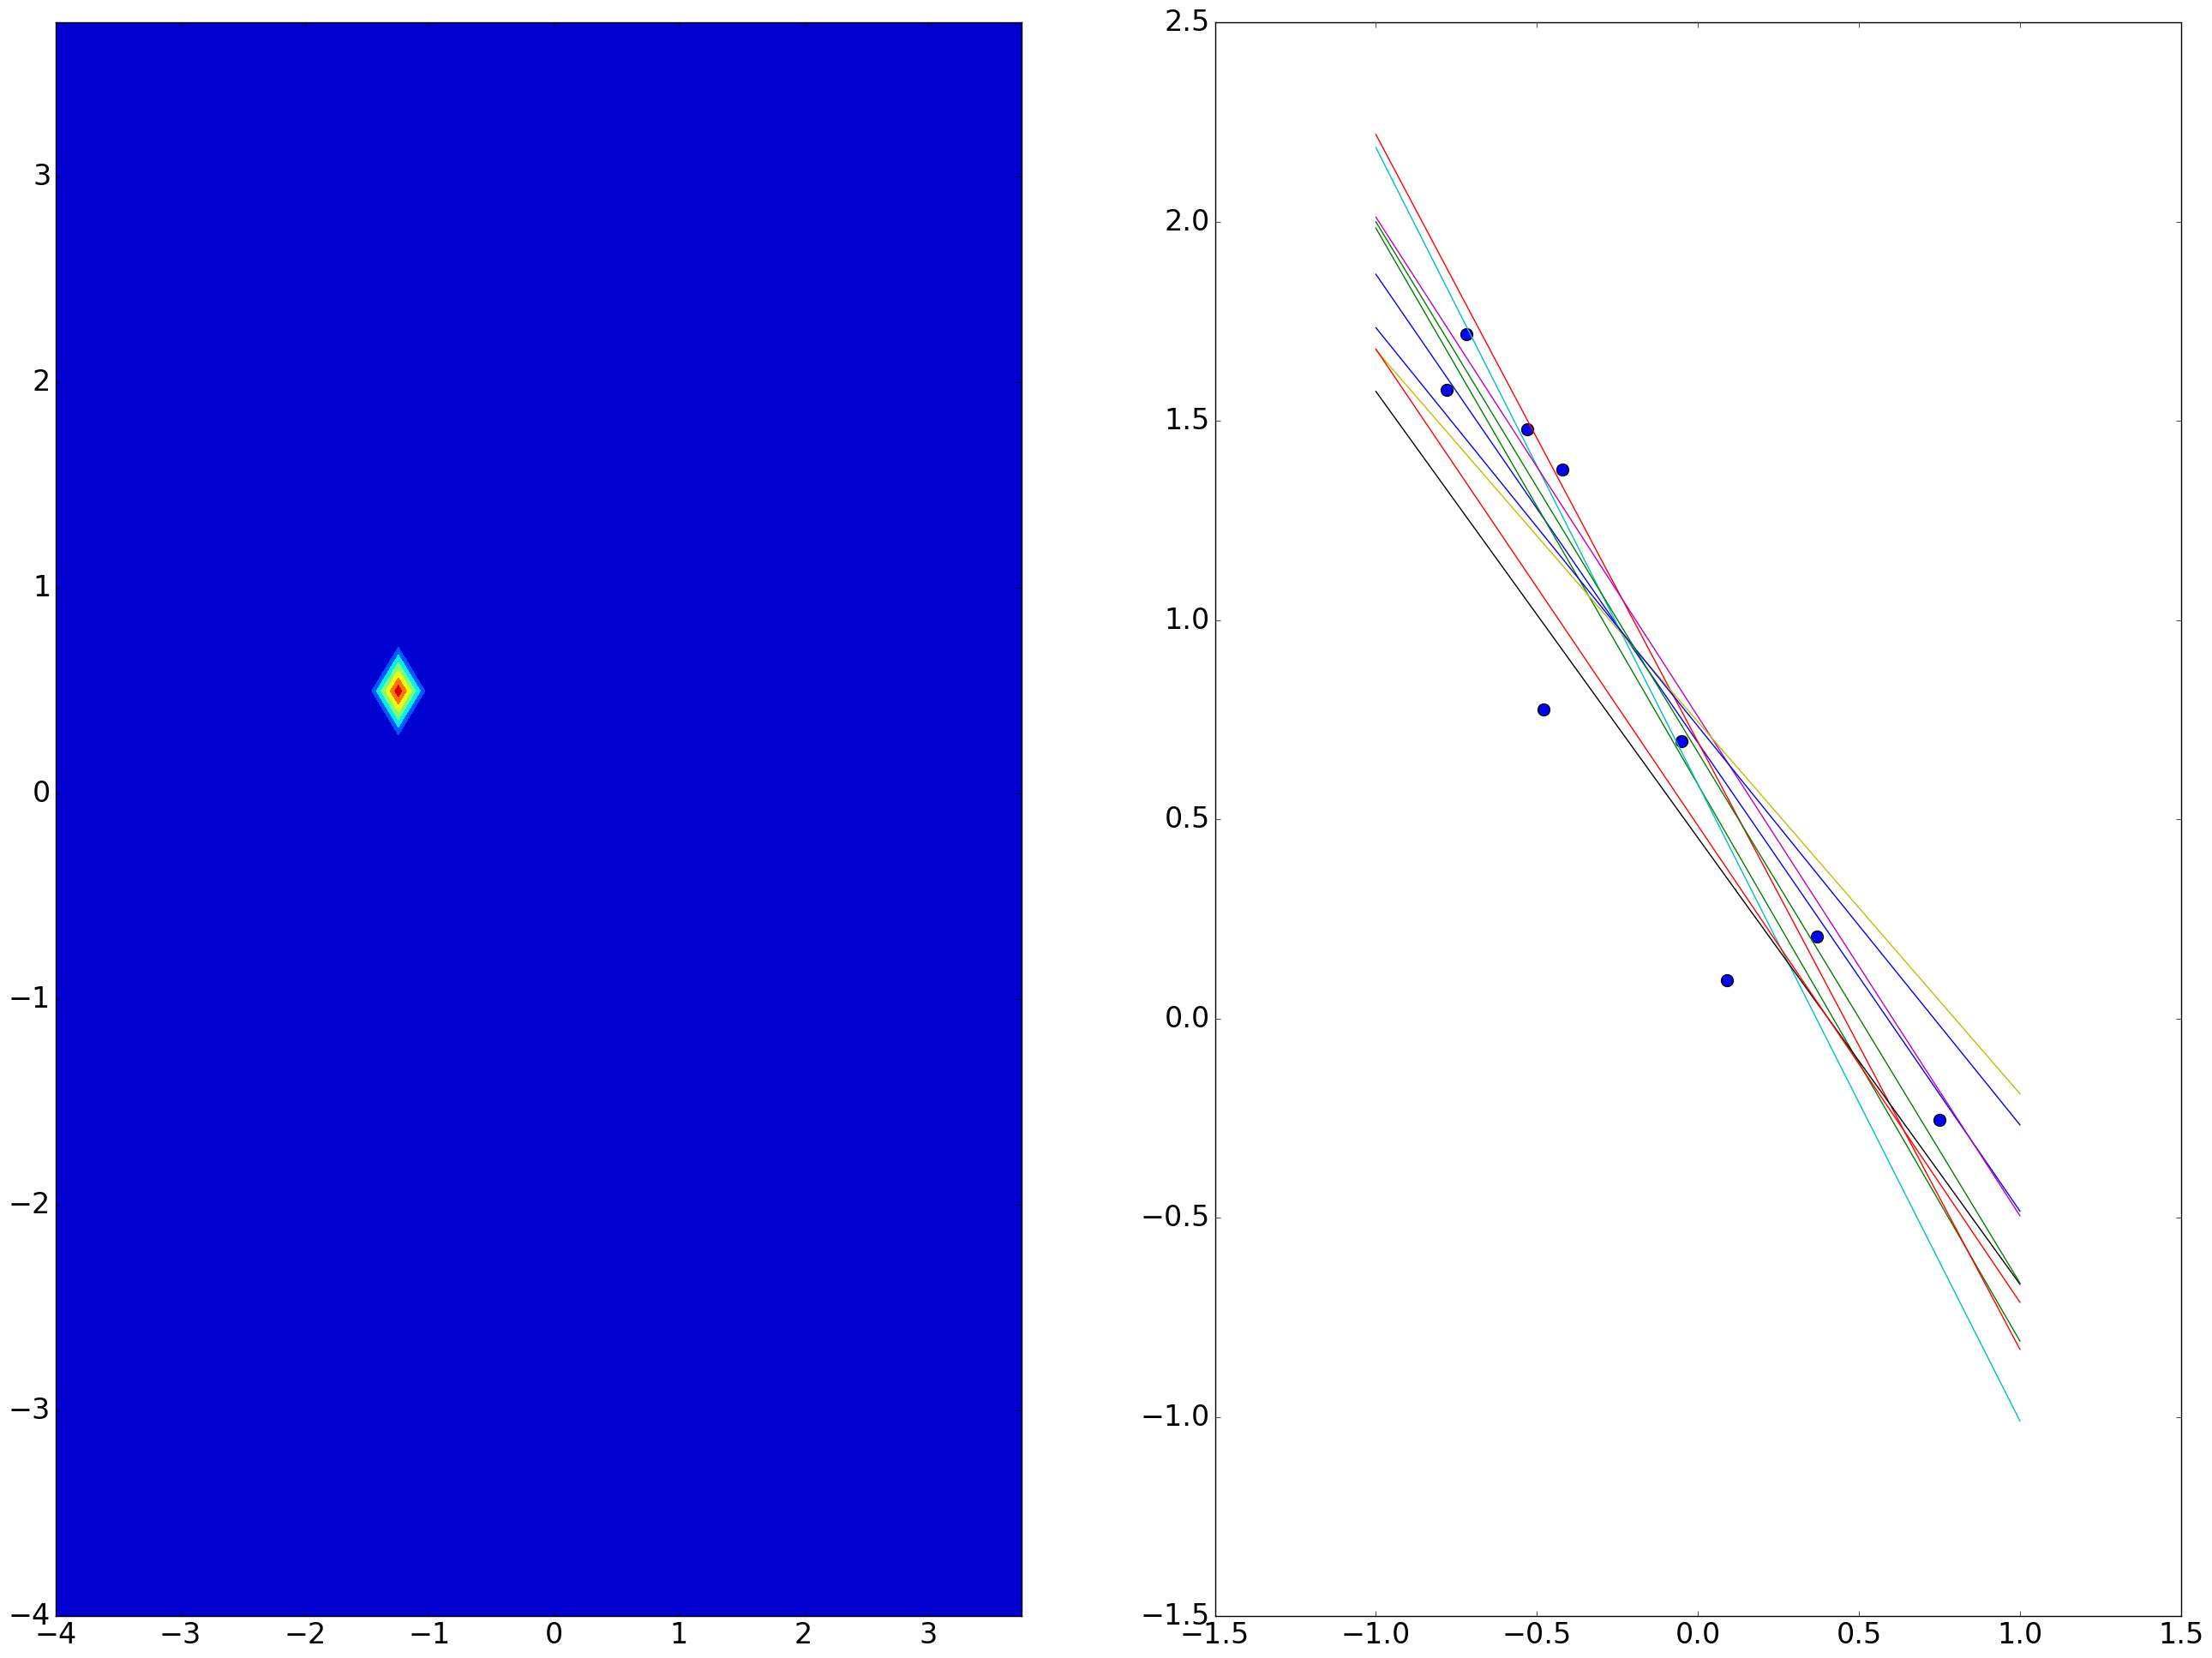

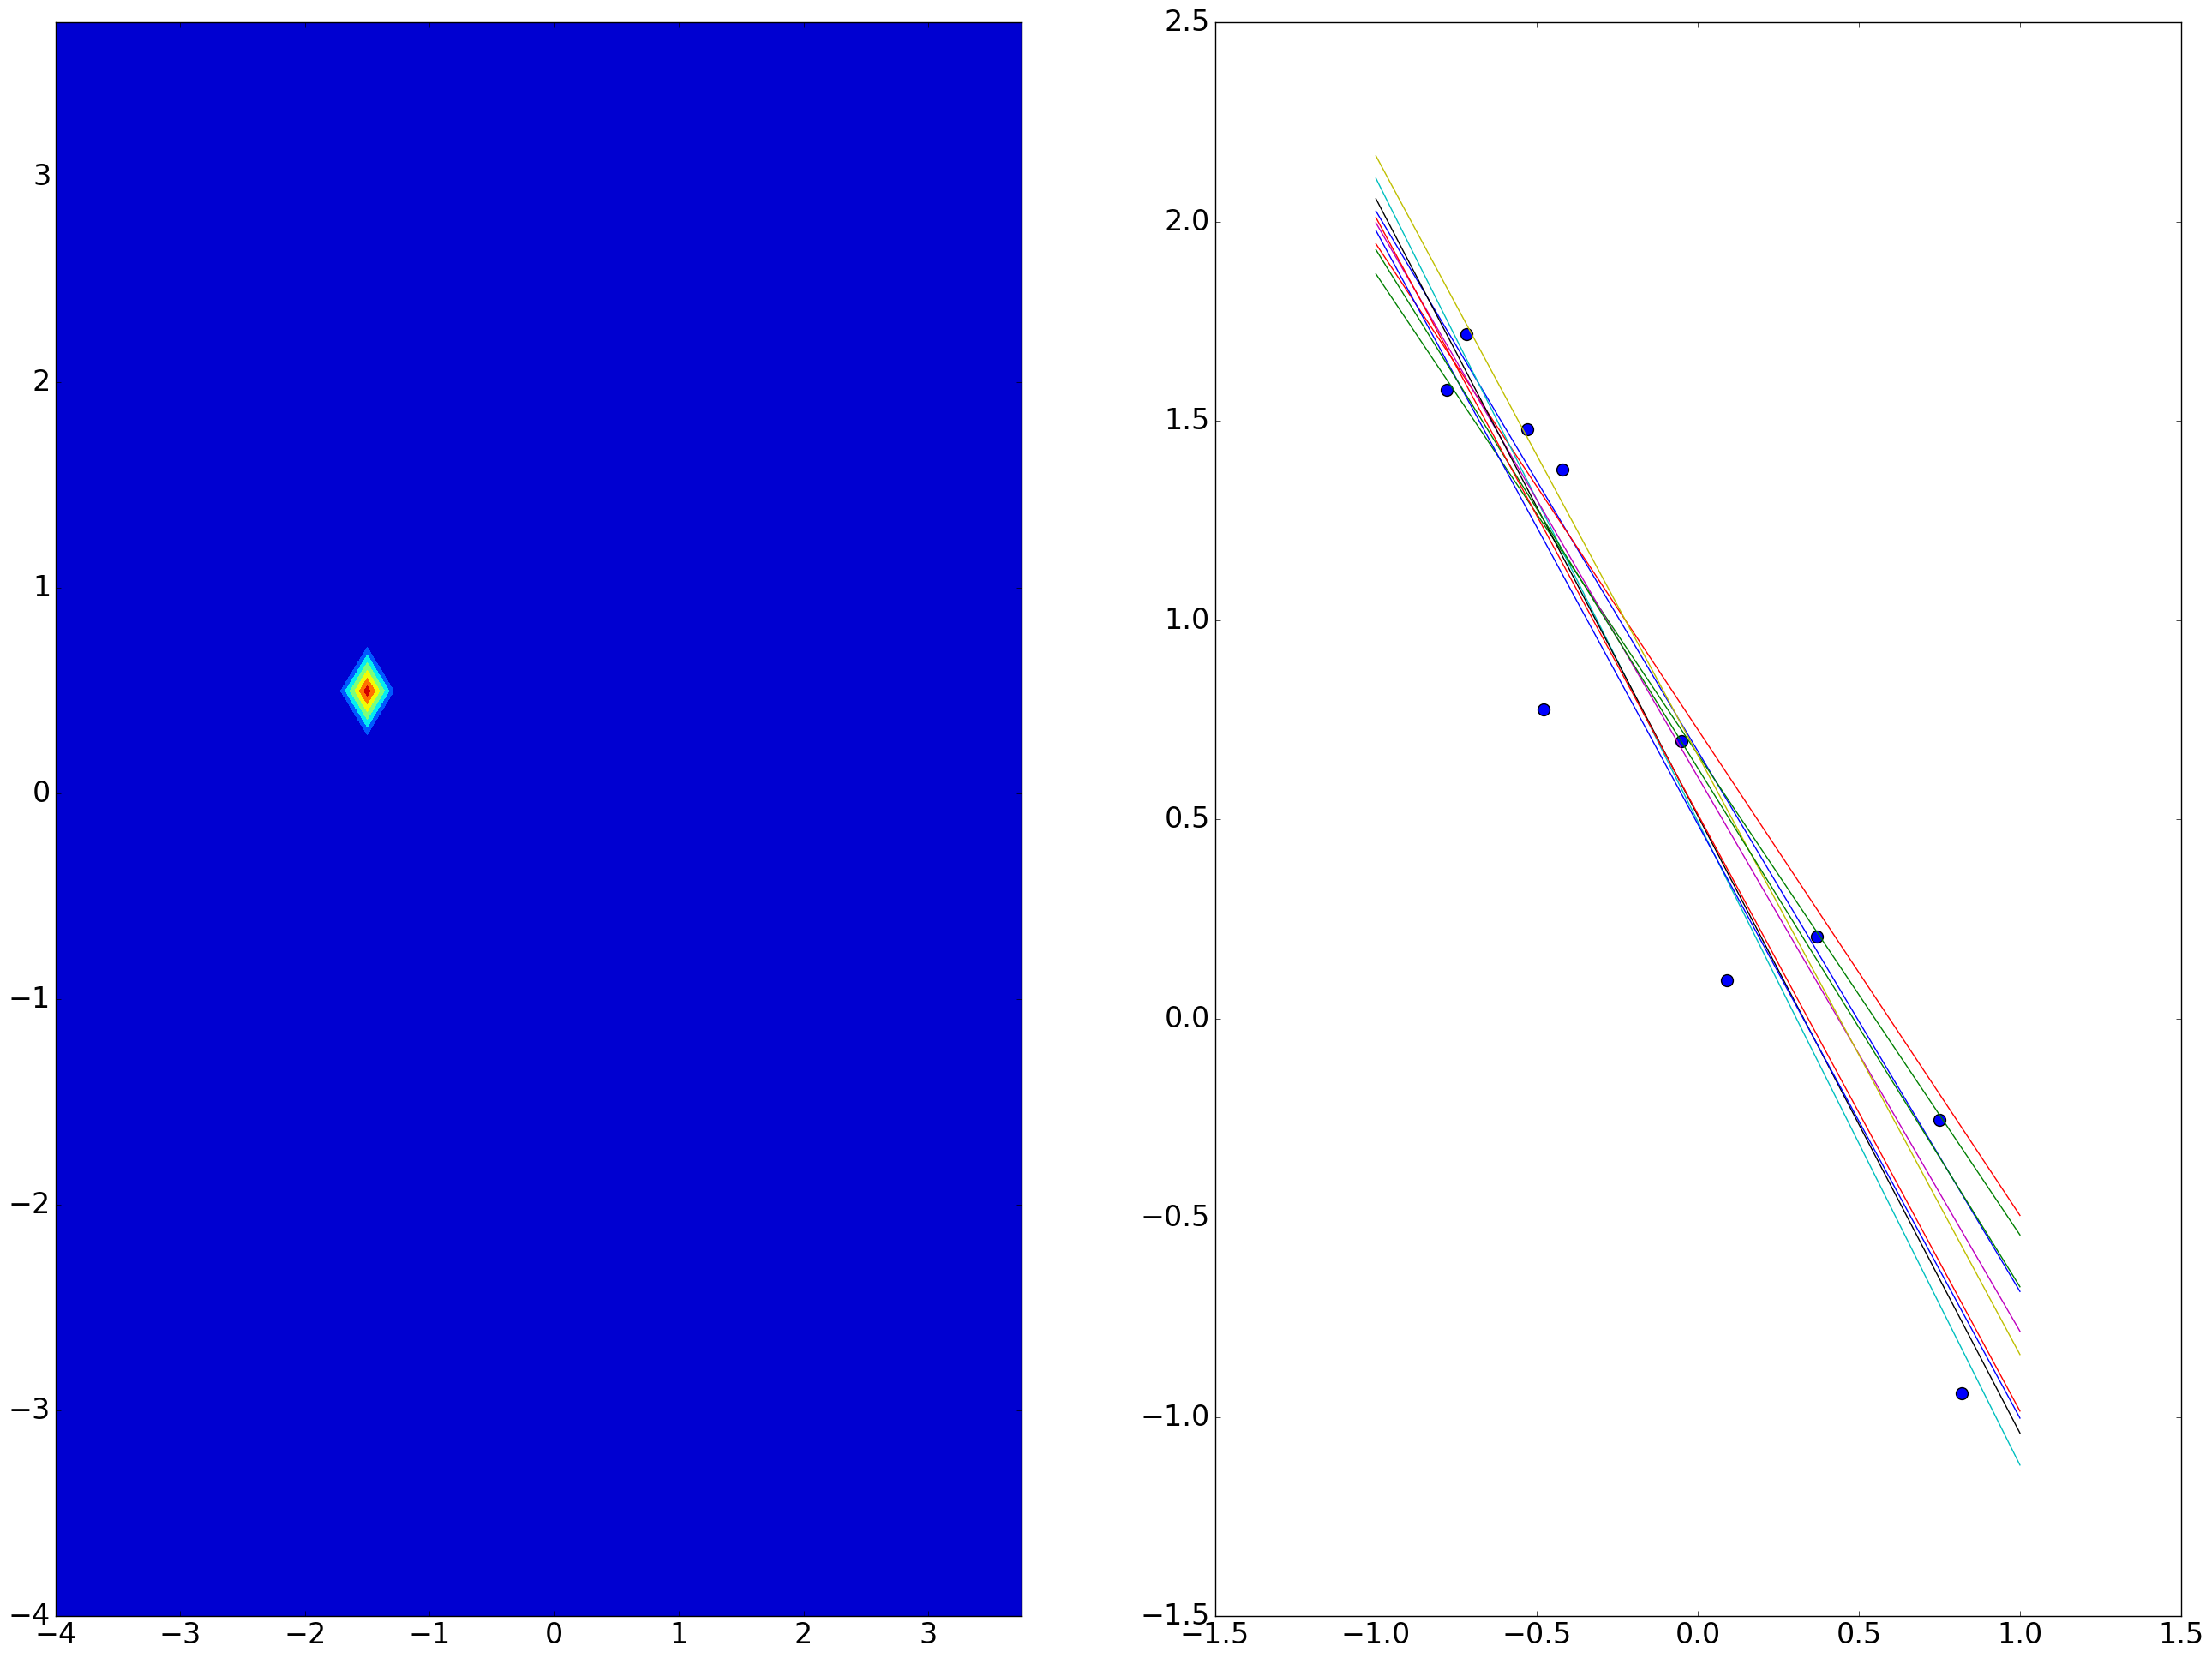

In [93]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.mlab as mlab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def y_i(w, x):
    epsilon = np.random.normal(0, 0.3)
    return np.dot(w, x) + epsilon

def visualise(ax, mu, cov):
    for i in range(10):
        w = np.random.multivariate_normal(mu, cov)
        ax.plot([-1, 1], [np.dot(w, [-1, 1]), np.dot(w, [1, 1])])

tau = 1
beta = (1/0.3) ** 2
w0 = [0, 0]

x = np.arange(0.01, 1.01, 0.01)
x = np.concatenate(((np.multiply(-1, list(reversed(x)))), [0], x))
W = [-1.3, 0.5]
y = [y_i(W, [x_i, 1]) for x_i in x]
cov = tau ** 2 * np.identity(2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

delta = 0.25
xr = np.arange(-4.0, 4.0, delta)
yr = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(xr, yr)
Z = mlab.bivariate_normal(X, Y, cov[0, 0], cov[1, 1], w0[0], w0[1])
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(X, Y, Z)
ax = fig.add_subplot(122)
visualise(ax, w0, cov)

xData, yData = unison_shuffled_copies(np.array(x), np.array(y))

mu = [w0]
sigma = [cov]
for i in range(5):
    xBias = np.ones((1, 2))
    xBias[:, 0] = xData[i]
    yCol = np.reshape(yData[i], (-1, 1))
    newSigma = np.linalg.inv(np.linalg.inv(sigma[i]) + beta * np.dot(xBias.T, xBias))
    sigma.append(newSigma)
    newMu = np.dot(newSigma, (np.dot(np.linalg.inv(sigma[i]), np.reshape(mu[i], (2,1))) + beta * np.dot(xBias.T, yCol)))
    newMu = newMu.flatten()
    mu.append(newMu)
    Z = mlab.bivariate_normal(X, Y, sigma[i+1][0][0], sigma[i+1][1][1], mu[i+1][0], mu[i+1][1])
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.contourf(X, Y, Z)
    ax = fig.add_subplot(122)
    visualise(ax, mu[i+1], sigma[i+1])
    ax.scatter(xData[0:i+1], yData[0:i+1], s=100)

plt.show()